# Борьба с дисбалансом в категориях (YOLO imgsz=1280)

## Импорты

In [1]:
import os
import json
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
import yaml
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from pathlib import Path
from tabulate import tabulate
import random
from IPython import display

c:\Innopolis\Zala_Project\venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Аугментация

In [ ]:
# Загрузка аннотаций
with open("archive/train_anno_with_categories.json", "r") as f:
    train_anno_2 = json.load(f)

# Создаем DataFrame из аннотаций
df_train = pd.DataFrame(train_anno_2["annotations"])

# Группируем по категориям и считаем количество
category_counts_train = df_train["category_name"].value_counts().reset_index()
category_counts_train.columns = ["Category", "Count"]

In [ ]:
category_counts_train

Category  Count
0  Особые предписания  41148
1    Знаки приоритета  16786
2         Запрещающие  12506
3     Предупреждающие   9166
4      Предписывающие   7198
5      Информационные   3393
6  С доп. информацией   3130
7           Сервисные   2165

In [ ]:
with open('data.yaml', 'r', encoding='utf-8') as f:
    data = yaml.safe_load(f)

In [12]:
data['names']

{0: 'Предупреждающие',
 1: 'Знаки приоритета',
 2: 'Запрещающие',
 3: 'Предписывающие',
 4: 'Особые предписания',
 5: 'Информационные',
 6: 'Сервисные',
 7: 'С доп. информацией'}

In [ ]:
# Пути
source_dir = r'c:\Innopolis\Zala_Project\rtsd_yolo_without_aug'
target_dir = r'c:\Innopolis\Zala_Project\rtsd_yolo_with_aug_2'

# Создаем целевую структуру папок
os.makedirs(os.path.join(target_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'val', 'labels'), exist_ok=True)

In [4]:
# Параметры аугментации (пример для миноритарных классов)
strong_aug = A.Compose([
    A.Rotate(limit=45, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.3)
], bbox_params=A.BboxParams(format='yolo', min_area=10, min_visibility=0.1))

In [5]:
# Количество копий для каждого класса
multipliers = {
    0: 3,  # Предупреждающие
    1: 2,  # Знаки приоритета
    2: 3,  # Запрещающие
    3: 4,  # Предписывающие
    4: 1,  # Особые предписания, не будем добавлять аугментацию
    5: 5,  # Информационные
    6: 5,  # Сервисные
    7: 5   # С доп. информацией
}

In [6]:
def process_dataset(subset='train'):
    images_dir = os.path.join(source_dir, subset, 'images')
    labels_dir = os.path.join(source_dir, subset, 'labels')
    
    # Собираем список всех изображений
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    # Создаем папки для аугментированных данных
    os.makedirs(os.path.join(target_dir, subset, 'images'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, subset, 'labels'), exist_ok=True)
    
    # Сначала копируем все оригинальные данные
    print(f"Копирование оригинальных {subset} данных...")
    for img_file in tqdm(image_files):
        src_img = os.path.join(images_dir, img_file)
        dst_img = os.path.join(target_dir, subset, 'images', img_file)
        shutil.copy2(src_img, dst_img)
        
        label_file = img_file.rsplit('.', 1)[0] + '.txt'
        src_label = os.path.join(labels_dir, label_file)
        dst_label = os.path.join(target_dir, subset, 'labels', label_file)
        if os.path.exists(src_label):
            shutil.copy2(src_label, dst_label)
    
    # Считаем количество объектов каждого класса в оригинальных данных
    original_class_counts = defaultdict(int)
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                original_class_counts[class_id] += 1
    
    # Словарь для отслеживания созданных аугментаций по классам
    augmented_class_counts = defaultdict(int)
    
    # Теперь применяем аугментацию
    print(f"\nПрименение аугментации для {subset}...")
    for img_file in tqdm(image_files):
        img_path = os.path.join(images_dir, img_file)
        img = np.array(Image.open(img_path))
        
        label_file = img_file.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)
        
        if not os.path.exists(label_path):
            continue
            
        # Читаем аннотации и фильтруем классы для аугментации
        with open(label_path) as f:
            lines = f.readlines()
        
        bboxes = []
        class_ids = []
        classes_in_image = set()
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            class_id = int(parts[0])
            if multipliers.get(class_id, 1) <= 1:  # Пропускаем классы с множителем <= 1
                continue
            xc, yc, w, h = map(float, parts[1:5])
            bboxes.append([xc, yc, w, h])
            class_ids.append(class_id)
            classes_in_image.add(class_id)
        
        if not classes_in_image:
            continue
            
        # Преобразуем в numpy array
        bboxes_np = np.array(bboxes, dtype=np.float32)
        
        # Определяем сколько копий нужно создать для каждого класса
        required_copies = {
            cls: (multipliers[cls] - 1) - (augmented_class_counts[cls] / original_class_counts[cls])
            for cls in classes_in_image
        }
        
        # Максимальное количество копий для этого изображения
        max_copies = max(1, int(max(required_copies.values()))) if required_copies else 0
        
        # Создаем аугментированные копии
        for copy_num in range(1, max_copies + 1):
            try:
                transformed = strong_aug(
                    image=img,
                    bboxes=bboxes_np,
                    class_labels=class_ids
                )
                img_aug = transformed['image']
                bboxes_aug = transformed['bboxes']
                
                # Проверяем, нужно ли сохранять эту копию
                save_copy = True
                for cls in classes_in_image:
                    if augmented_class_counts[cls] >= (multipliers[cls] - 1) * original_class_counts[cls]:
                        save_copy = False
                        break
                
                if save_copy:
                    # Сохраняем результат
                    new_img_name = f'aug_{copy_num}_{img_file}'
                    new_label_name = f'aug_{copy_num}_{label_file}'
                    
                    Image.fromarray(img_aug).save(
                        os.path.join(target_dir, subset, 'images', new_img_name)
                    )
                    
                    with open(os.path.join(target_dir, subset, 'labels', new_label_name), 'w') as f:
                        for bbox, class_id in zip(bboxes_aug, class_ids):
                            f.write(f"{class_id} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
                    
                    # Обновляем счетчики для каждого класса
                    for cls in classes_in_image:
                        augmented_class_counts[cls] += list(class_ids).count(cls)
                        
            except Exception as e:
                print(f"Ошибка при обработке {img_file}: {str(e)}")
                continue

In [7]:
# Обрабатываем train
process_dataset('train')

Копирование оригинальных train данных...


100%|██████████| 54188/54188 [01:30<00:00, 598.07it/s]



Применение аугментации для train...


100%|██████████| 54188/54188 [25:02<00:00, 36.07it/s] 


In [8]:
# Копируем оригиналы в val
def copy_val_data(source_dir, target_dir):
    source_val = os.path.join(source_dir, 'val')
    target_val = os.path.join(target_dir, 'val')
    
    # Создаем подпапки если их нет
    os.makedirs(os.path.join(target_val, 'images'), exist_ok=True)
    os.makedirs(os.path.join(target_val, 'labels'), exist_ok=True)
    
    # Копируем изображения
    for img_file in os.listdir(os.path.join(source_val, 'images')):
        src = os.path.join(source_val, 'images', img_file)
        dst = os.path.join(target_val, 'images', img_file)
        shutil.copy2(src, dst)
    
    # Копируем аннотации
    for label_file in os.listdir(os.path.join(source_val, 'labels')):
        src = os.path.join(source_val, 'labels', label_file)
        dst = os.path.join(target_val, 'labels', label_file)
        shutil.copy2(src, dst)
        
        
copy_val_data(source_dir, target_dir)

Showing aug_1_autosave09_10_2012_14_27_19_3.jpg


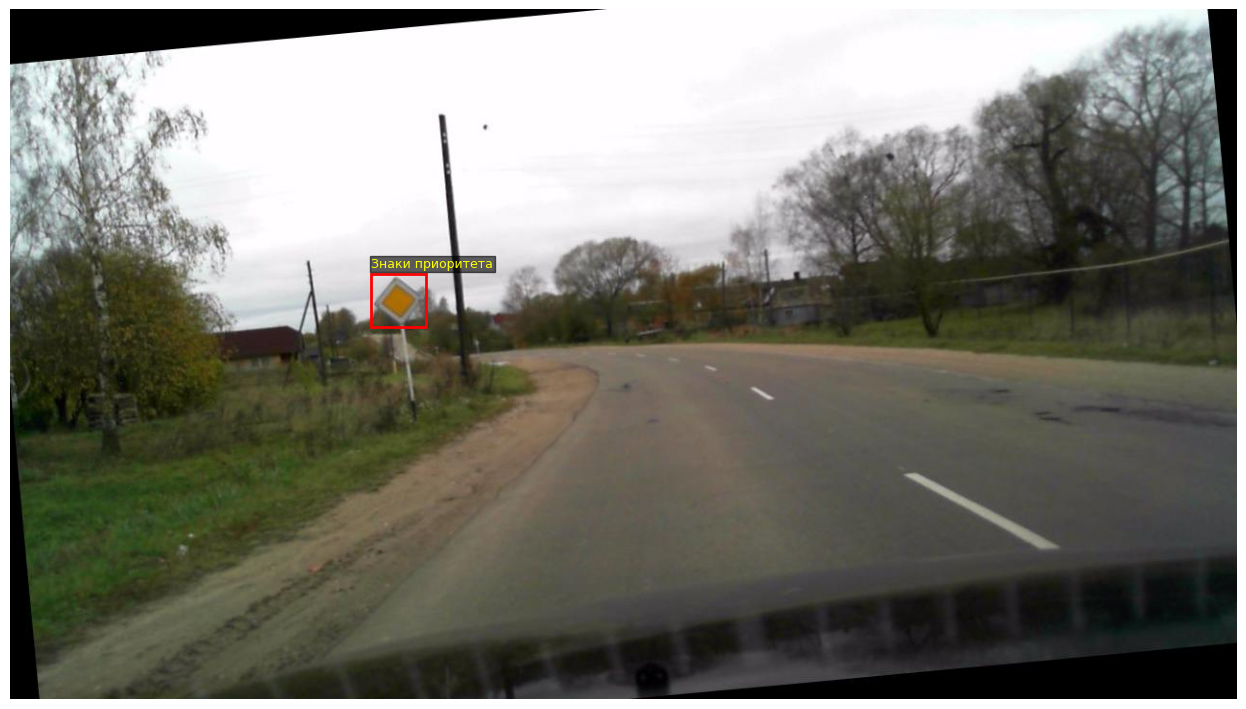

Showing aug_2_autosave09_10_2012_12_58_33_0.jpg


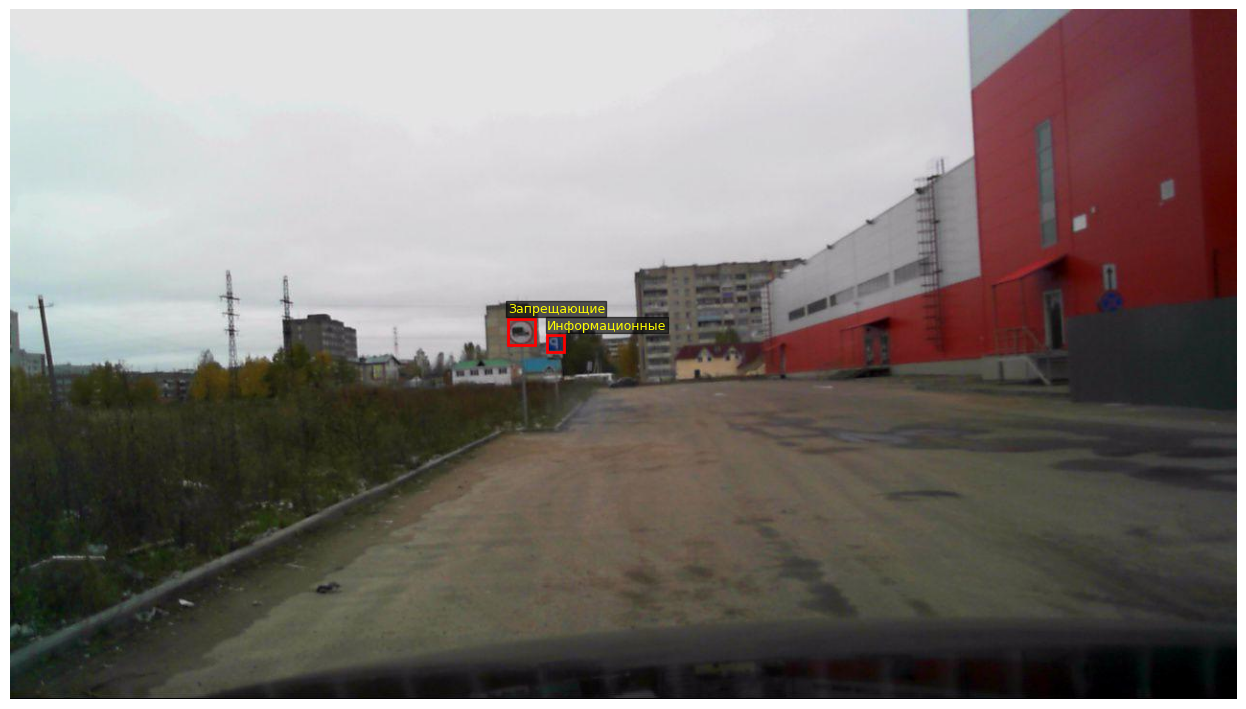

Showing aug_1_autosave09_10_2012_08_52_41_1.jpg


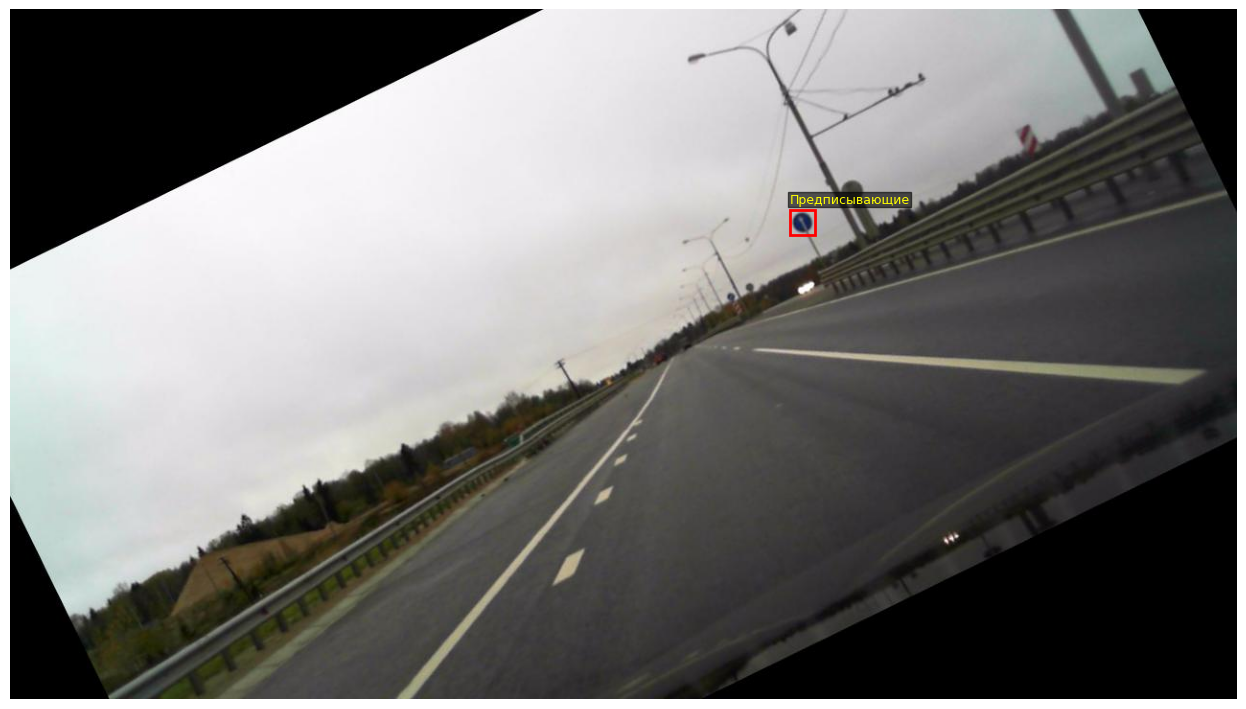

Showing aug_1_autosave13_04_2013_12_35_07_1.jpg


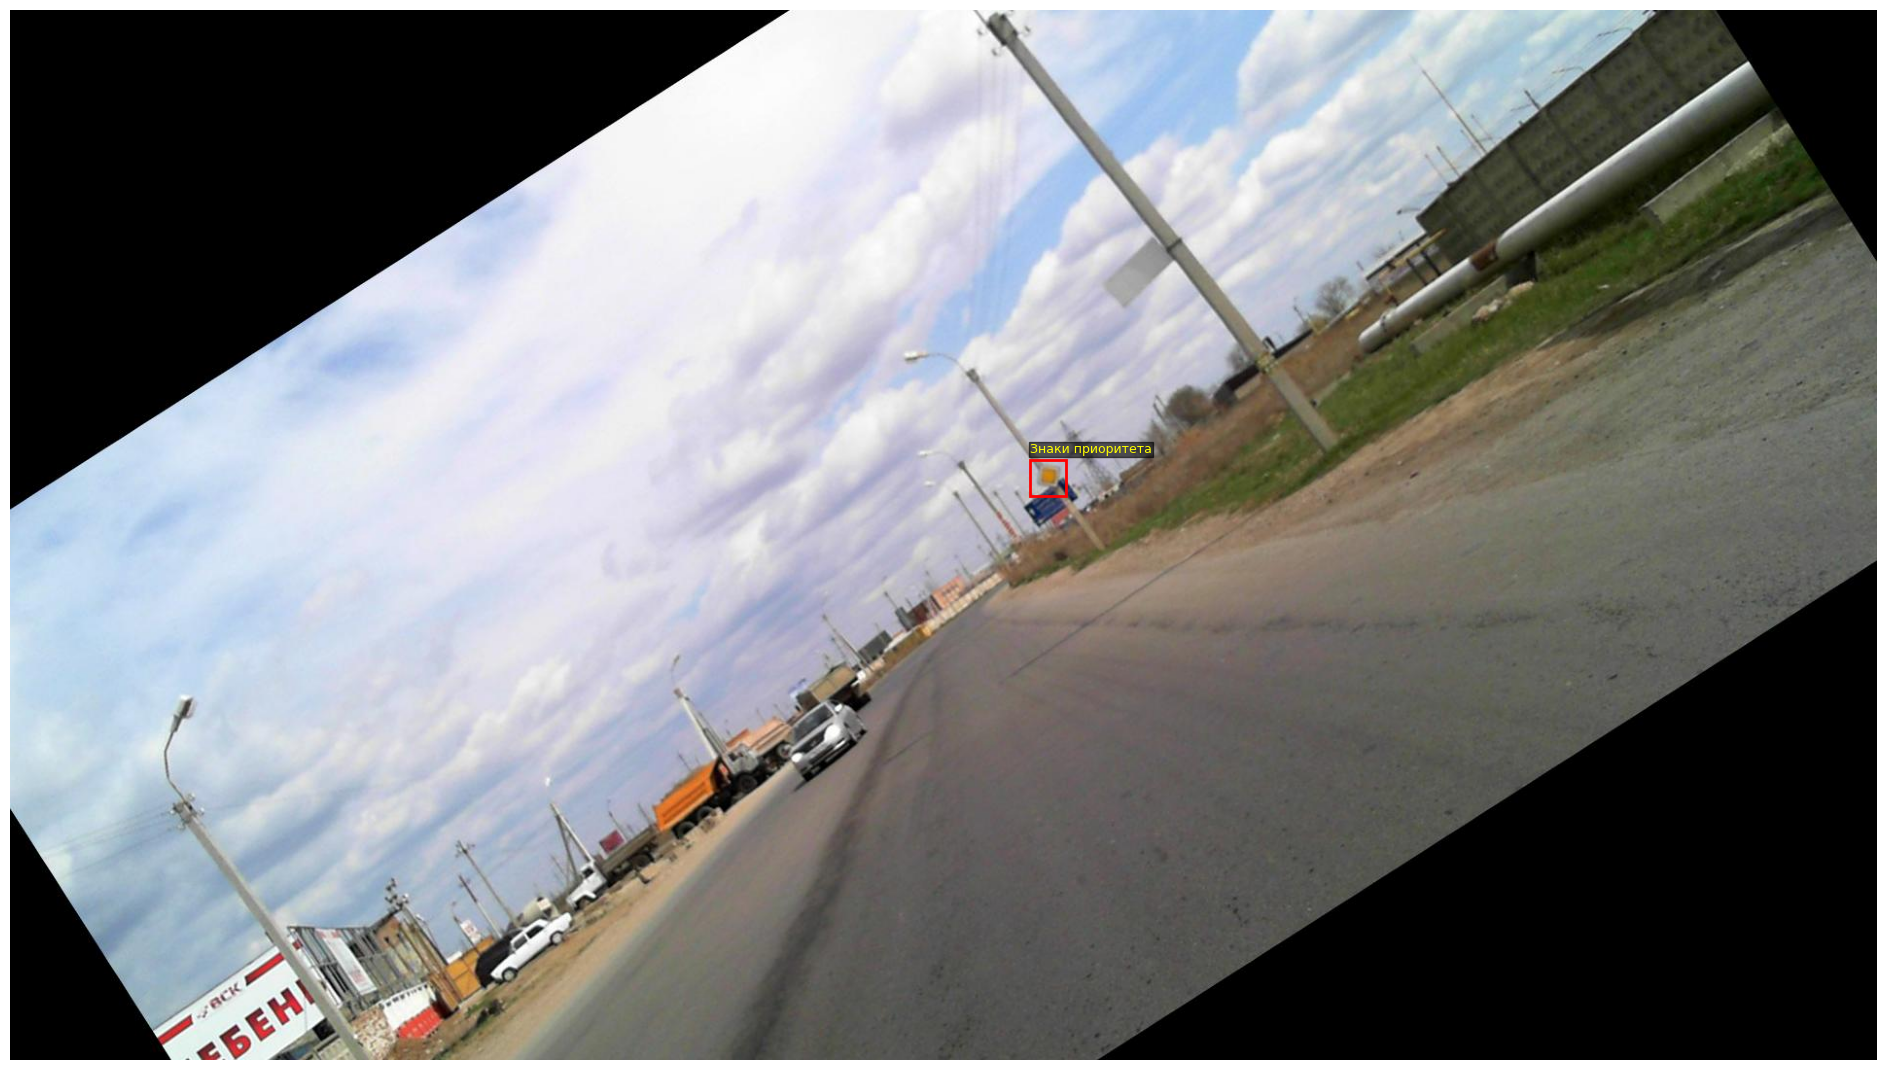

Showing aug_1_autosave09_10_2012_13_28_32_2.jpg


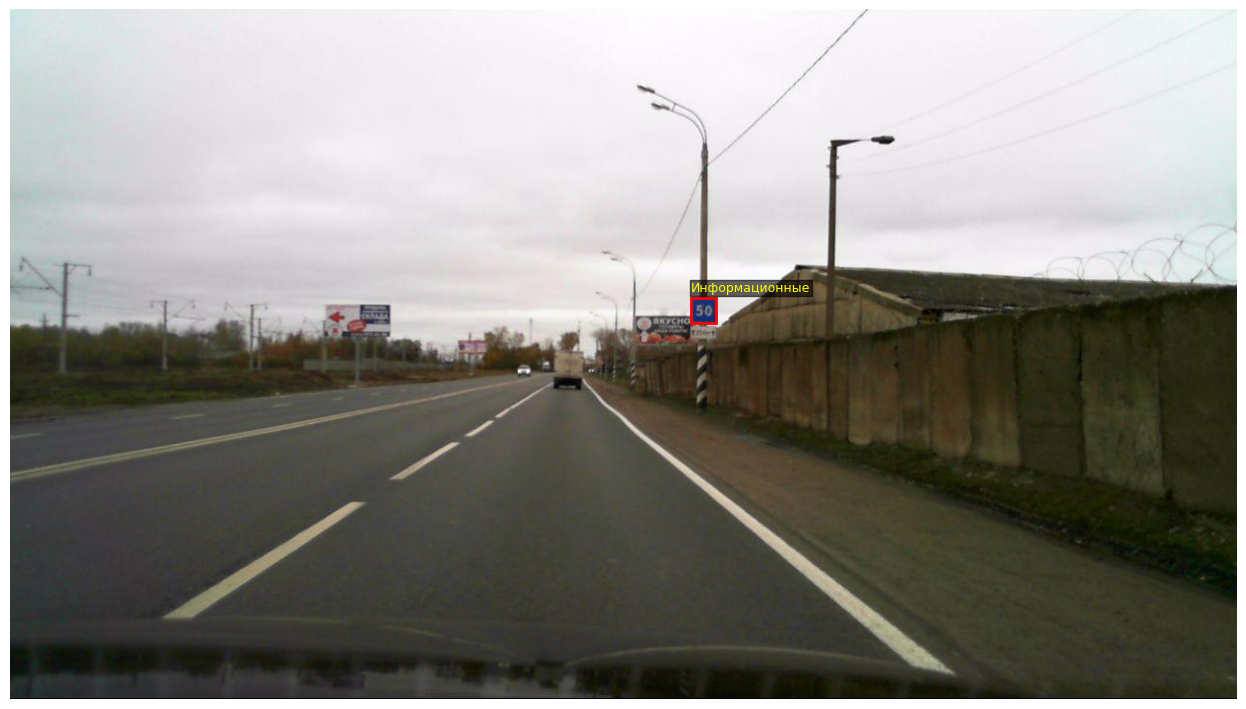

In [4]:
def visualize_yolo_bbox(image_path, label_path, class_names):
    img = Image.open(image_path)
    width, height = img.size

    # Переводим пиксели в дюймы (допустим, 100 dpi)
    dpi = 100
    figsize = (width / dpi, height / dpi)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)

    if not os.path.exists(label_path):
        print(f"Label not found for {os.path.basename(image_path)}")
        return

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id = int(parts[0])
            x_center, y_center, w, h = map(float, parts[1:])

            x = (x_center - w / 2) * width
            y = (y_center - h / 2) * height
            w_abs = w * width
            h_abs = h * height

            rect = patches.Rectangle(
                (x, y), w_abs, h_abs,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(x, y - 7, class_names[class_id], color='yellow', fontsize=9,
                    bbox=dict(facecolor='black', alpha=0.6, pad=1))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_random_augmented_samples(images_dir, labels_dir, class_names, num_samples=5, random_seed=42):
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg')) and f.startswith('aug_')]
    if len(image_files) == 0:
        print("No augmented images found in the directory.")
        return

    random.seed(random_seed)
    samples = random.sample(image_files, min(num_samples, len(image_files)))
    for img_file in samples:
        img_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, img_file.rsplit('.', 1)[0] + '.txt')
        print(f"Showing {img_file}")
        visualize_yolo_bbox(img_path, label_path, class_names)
        
source_dir = r'c:\Innopolis\Zala_Project\rtsd_yolo_without_aug'
target_dir = r'c:\Innopolis\Zala_Project\rtsd_yolo_with_aug_2'
# Параметры
target_dir = target_dir
subset = 'train'
images_dir = os.path.join(target_dir, subset, 'images')
labels_dir = os.path.join(target_dir, subset, 'labels')

class_names = {
    0: 'Предупреждающие',
    1: 'Знаки приоритета',
    2: 'Запрещающие',
    3: 'Предписывающие',
    4: 'Особые предписания',
    5: 'Информационные',
    6: 'Сервисные',
    7: 'С доп. информацией'
}

# Показываем 5 случайных аугментированных изображений с bbox

show_random_augmented_samples(images_dir, labels_dir, class_names, num_samples=5, random_seed=1)

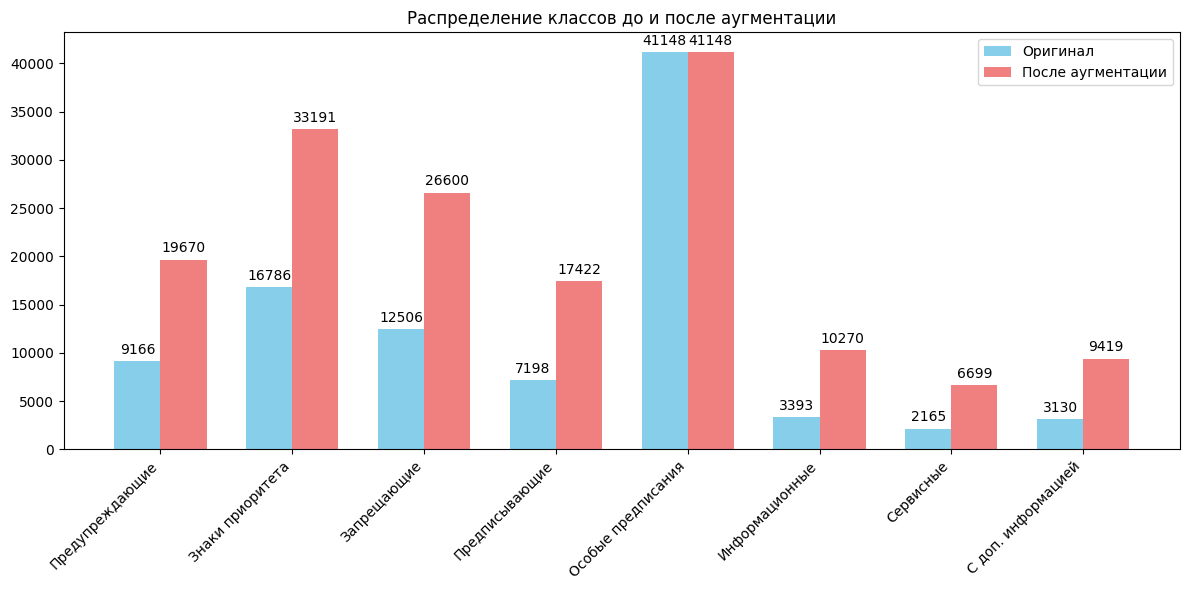

In [ ]:
def plot_class_distribution(original_dir, augmented_dir, class_names):
    # Считаем количество примеров в оригинальном датасете
    original_counts = count_classes_in_labels(original_dir)
    
    # Считаем количество примеров в аугментированном датасете
    augmented_counts = count_classes_in_labels(augmented_dir)
    
    # Подготовка данных для графика
    x = np.arange(len(class_names))
    width = 0.35  # Ширина столбцов

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, original_counts, width, label='Оригинал', color='skyblue')
    rects2 = ax.bar(x + width/2, augmented_counts, width, label='После аугментации', color='lightcoral')

    # Настройки графика
    ax.set_title('Распределение классов до и после аугментации')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    plt.tight_layout()
    plt.show()

def count_classes_in_labels(data_dir):
    class_counts = defaultdict(int)
    labels_dir = os.path.join(data_dir, 'train', 'labels')
    
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
            
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1
                
    # Возвращаем список в порядке классов (0-7)
    return [class_counts[i] for i in range(8)]

# Ваши названия классов
class_names = [
    "Предупреждающие",
    "Знаки приоритета",
    "Запрещающие",
    "Предписывающие",
    "Особые предписания",
    "Информационные",
    "Сервисные",
    "С доп. информацией"
]

# Пути к данным
original_dir = r'c:\Innopolis\Zala_Project\rtsd_yolo_without_aug'
augmented_dir = r'c:\Innopolis\Zala_Project\rtsd_yolo_with_aug_2'

# Строим график
plot_class_distribution(original_dir, augmented_dir, class_names)

In [ ]:
# Пути относительно расположения data3.yaml
data3 = {
    'path': str(Path('rtsd_yolo_with_aug_2').absolute()),  # корневая папка датасета
    'train': 'train/images',  # относительно 'path'
    'val': 'val/images',
    'names': {
        0: 'Предупреждающие',
        1: 'Знаки приоритета',
        2: 'Запрещающие',
        3: 'Предписывающие',
        4: 'Особые предписания',
        5: 'Информационные',
        6: 'Сервисные',
        7: 'С доп. информацией'
    }
}

# Сохранение файла
with open('data3.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(data3, f, allow_unicode=True, sort_keys=False)

print("Файл data.yaml создан. Содержимое:")
print(yaml.dump(data3, allow_unicode=True, sort_keys=False))

Файл data.yaml создан. Содержимое:
path: c:\Innopolis\Zala_Project\rtsd_yolo_with_aug_2
train: train/images
val: val/images
names:
  0: Предупреждающие
  1: Знаки приоритета
  2: Запрещающие
  3: Предписывающие
  4: Особые предписания
  5: Информационные
  6: Сервисные
  7: С доп. информацией



### Обучение модели YOLO11s (для imgsz=1280)

In [2]:
# Инициализация модели
model_11s_balanced_aug_2 = YOLO('yolo11s.pt')

# Параметры обучения
results = model_11s_balanced_aug_2.train(
    data='data3.yaml',
    epochs=10,  
    patience=2,  # Остановка при отсутствии улучшений
    batch=4,  
    imgsz=1280,  # Не уменьшать для дорожных знаков
    device=0,  # Использовать GPU
    workers=2,  # Потоки загрузки данных
    optimizer='AdamW',  # Лучше для transfer learning
    lr0=0.001,  # Learning rate
    lrf=0.01,  # Final LR = lr0 * lrf
    weight_decay=0.0005,
    amp=True,  # Mixed Precision (ускорение + экономия памяти)
    cache=True,  # Кеширование (требует RAM)
    single_cls=False,  # У нас 8 классов
    pretrained=True,  # Использовать предобученные веса
    plots=True,  # Генерация графиков
    project='RTSD_YOLOv11_s_aug_2',
    name='yolov11_s_aug_2',
    augment=False
)

New https://pypi.org/project/ultralytics/8.3.137 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.112  Python-3.12.8 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=data3.yaml, epochs=10, time=None, patience=2, batch=4, imgsz=1280, save=True, save_period=-1, cache=True, device=0, workers=2, project=RTSD_YOLOv11_s_aug_2, name=yolov11_s_aug_2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

train: Scanning C:\Innopolis\Zala_Project\rtsd_yolo_with_aug_2\train\labels.cache... 100345 images, 1189 backgrounds, 0 corrupt: 100%|██████████| 100345/100345 [00:00<?, ?it/s]


WARNING train: 387.6GB RAM required to cache images with 50% safety margin but only 4.4/15.9GB available, not caching images
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.40.2 ms, read: 31.922.0 MB/s, size: 112.7 KB)


val: Scanning C:\Innopolis\Zala_Project\rtsd_yolo_with_aug_2\val\labels.cache... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


WARNING val: 19.3GB RAM required to cache images with 50% safety margin but only 3.3/15.9GB available, not caching images
Plotting labels to RTSD_YOLOv11_s_aug_2\yolov11_s_aug_2\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to RTSD_YOLOv11_s_aug_2\yolov11_s_aug_2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.42G      1.283      1.151      1.148          2       1280: 100%|██████████| 25087/25087 [1:49:13<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:11<00:00,  8.76it/s]

                   all       5000       8866       0.85       0.86      0.902      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.34G      1.165     0.8462      1.097          1       1280: 100%|██████████| 25087/25087 [1:46:30<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:10<00:00,  8.90it/s]

                   all       5000       8866      0.865       0.88      0.923      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.51G       1.12      0.759      1.071          1       1280: 100%|██████████| 25087/25087 [1:46:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:10<00:00,  8.89it/s]

                   all       5000       8866      0.863        0.9      0.931      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.36G      1.083     0.7012      1.051          1       1280: 100%|██████████| 25087/25087 [1:45:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:09<00:00,  9.04it/s]

                   all       5000       8866      0.872      0.904      0.936      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.37G       1.05     0.6548      1.036          1       1280: 100%|██████████| 25087/25087 [1:45:48<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:09<00:00,  9.03it/s]

                   all       5000       8866      0.879      0.906       0.94      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.35G      1.025     0.6229      1.024          2       1280: 100%|██████████| 25087/25087 [1:45:31<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:08<00:00,  9.06it/s]

                   all       5000       8866      0.884      0.901      0.942      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.36G      1.003     0.5958      1.014          1       1280: 100%|██████████| 25087/25087 [1:45:04<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:08<00:00,  9.09it/s]

                   all       5000       8866      0.891      0.897      0.944      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.35G     0.9827     0.5704      1.003          3       1280: 100%|██████████| 25087/25087 [1:45:47<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:09<00:00,  8.94it/s]

                   all       5000       8866      0.893      0.896      0.946      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.51G     0.9628     0.5482     0.9941          5       1280: 100%|██████████| 25087/25087 [1:46:29<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:13<00:00,  8.46it/s]

                   all       5000       8866      0.899      0.896      0.947      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.35G     0.9463     0.5298     0.9863          2       1280: 100%|██████████| 25087/25087 [1:48:35<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:16<00:00,  8.18it/s]


                   all       5000       8866      0.892      0.905      0.948      0.719

10 epochs completed in 17.947 hours.
Optimizer stripped from RTSD_YOLOv11_s_aug_2\yolov11_s_aug_2\weights\last.pt, 19.2MB
Optimizer stripped from RTSD_YOLOv11_s_aug_2\yolov11_s_aug_2\weights\best.pt, 19.2MB

Validating RTSD_YOLOv11_s_aug_2\yolov11_s_aug_2\weights\best.pt...
Ultralytics 8.3.112  Python-3.12.8 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:06<00:00,  9.41it/s]


                   all       5000       8866      0.891      0.905      0.948      0.719
               744        832      0.932      0.948       0.98      0.741
              1469       1542      0.929      0.951      0.981       0.77
                  1035       1136       0.91      0.919      0.966      0.736
                580        660      0.928      0.941      0.973      0.722
            2383       3913      0.928      0.882      0.965      0.726
                313        320      0.866      0.867      0.942      0.686
                     186        198      0.915      0.955      0.981      0.777
     .         245        265      0.724      0.781      0.797      0.589
Speed: 0.6ms preprocess, 8.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to RTSD_YOLOv11_s_aug_2\yolov11_s_aug_2


In [5]:
# Загрузка лучшей модели
best_model_11s_aug_1280 = YOLO('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/weights/best.pt')
best_model_11s_aug_1280

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_runnin

**В результате обучения создается папка с сохраненными весами, логами, параметрами обучения и графиками.**

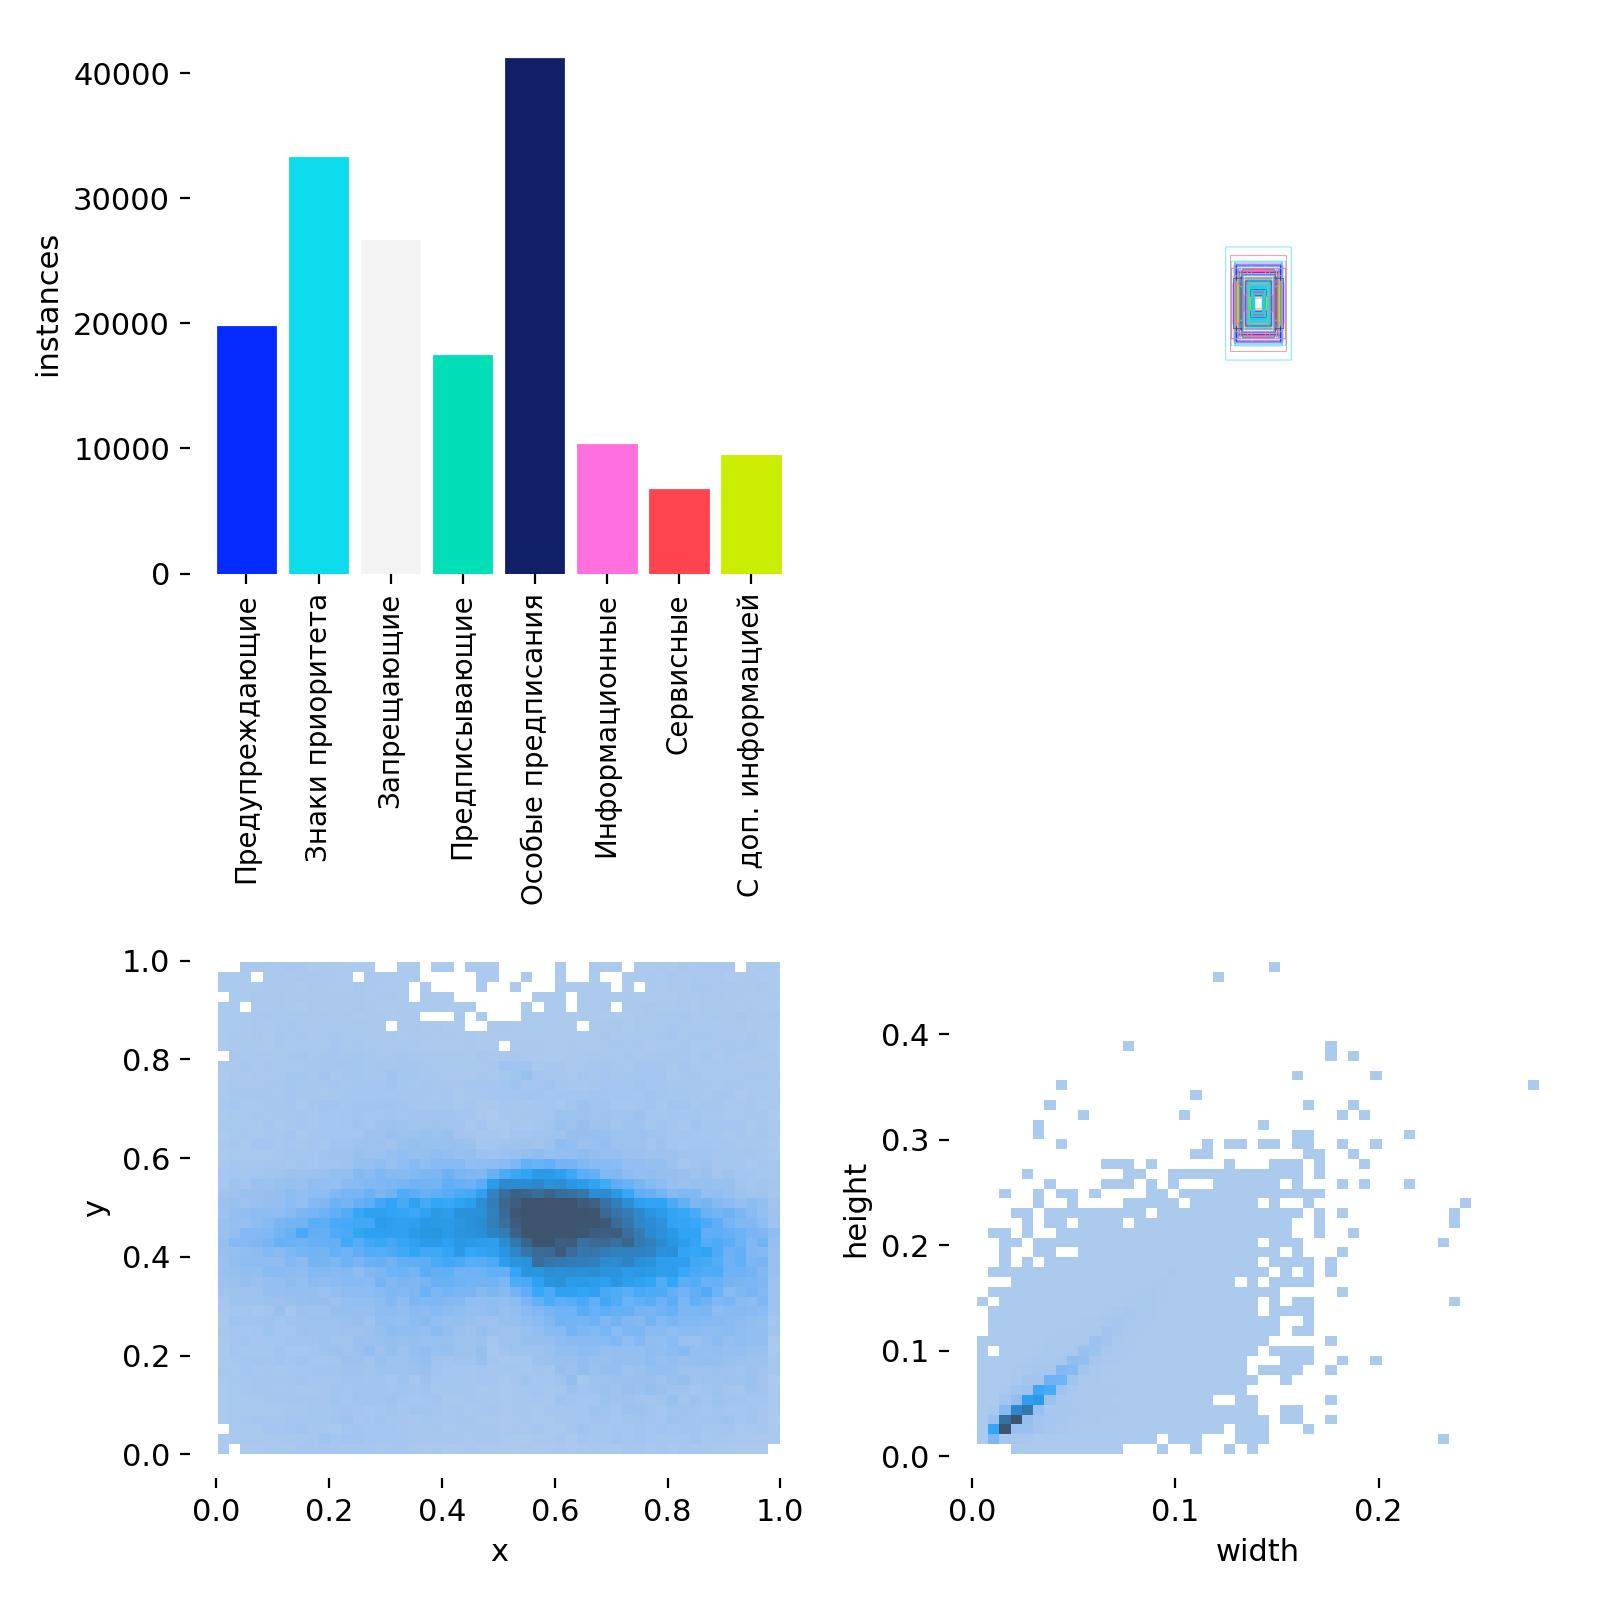

In [6]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/labels.jpg', width=900, height=600)

**Матрица ошибок (confusion matrix) между предсказанными и реальными классами.**

По оси Х — истинные классы (True)

По оси Y — предсказанные (Predicted)

Ячейки: сколько раз модель предсказала Y при наличии X

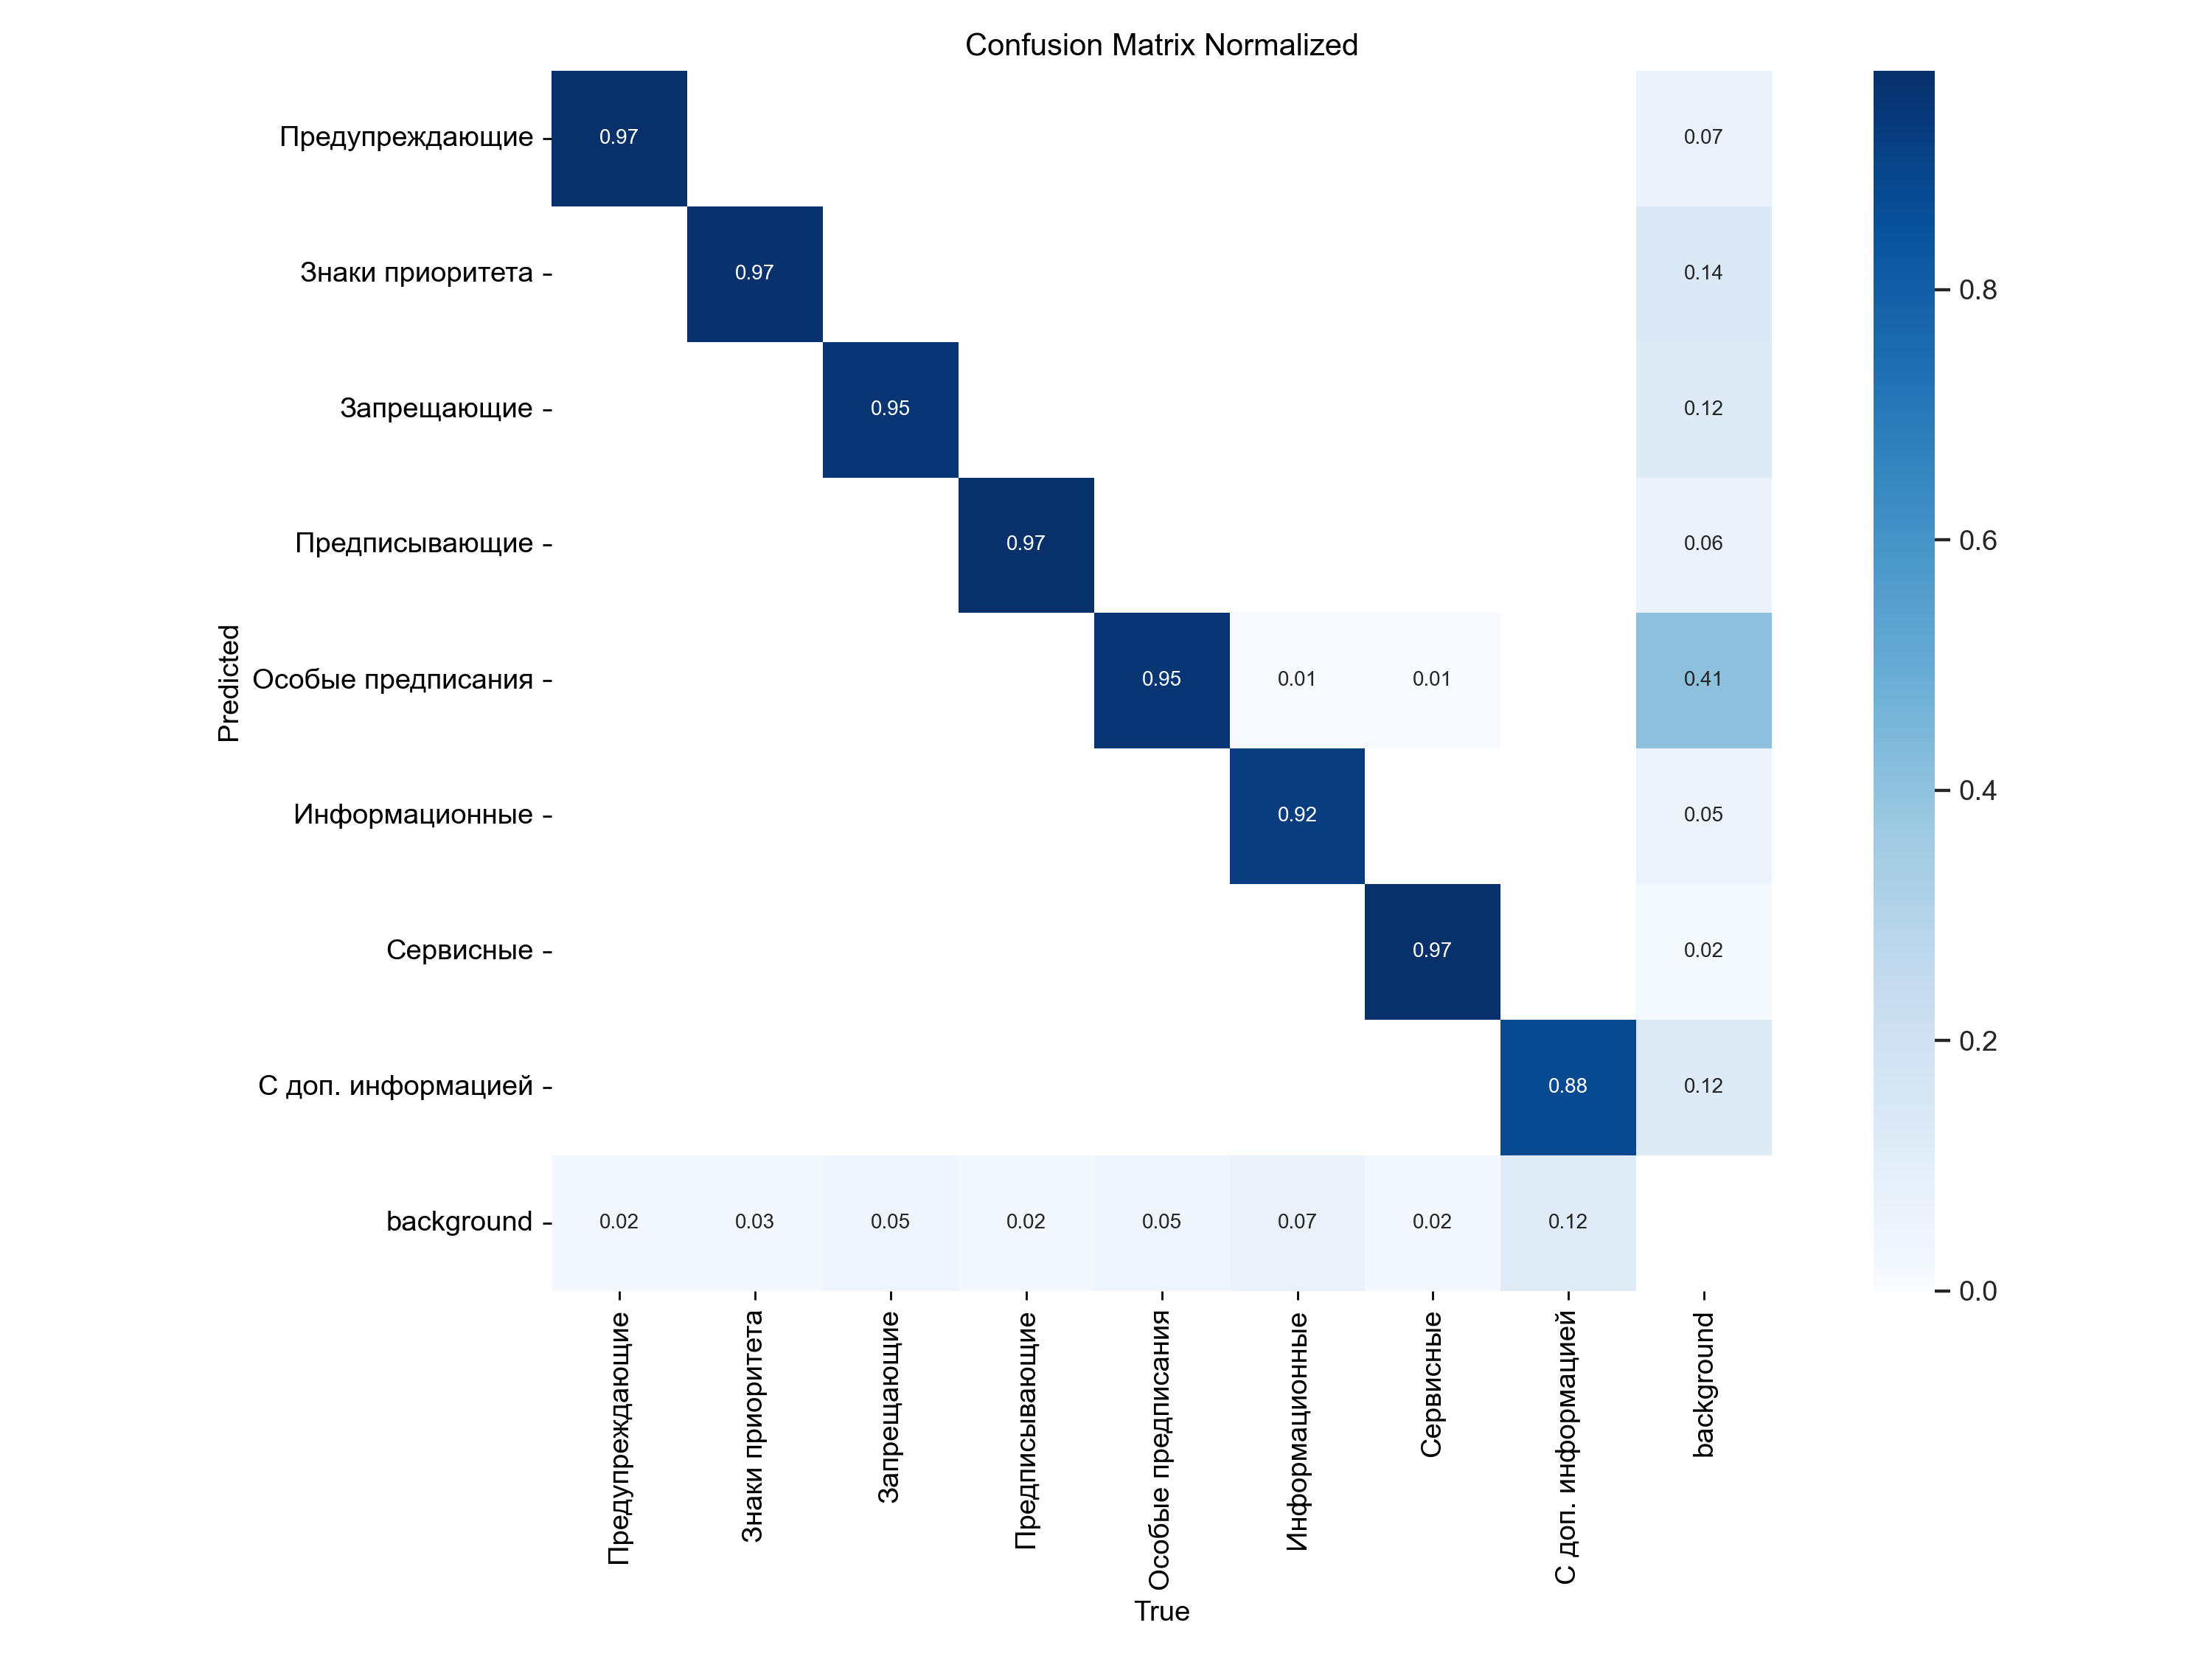

In [7]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/confusion_matrix_normalized.png', width=1200, height=900)

**PR-кривая (Precision vs Recall) — важная кривая для каждой категории:**

Каждая линия — это отдельный класс.

Чем выше и правее линия, тем лучше модель: высокая точность при высокой полноте.

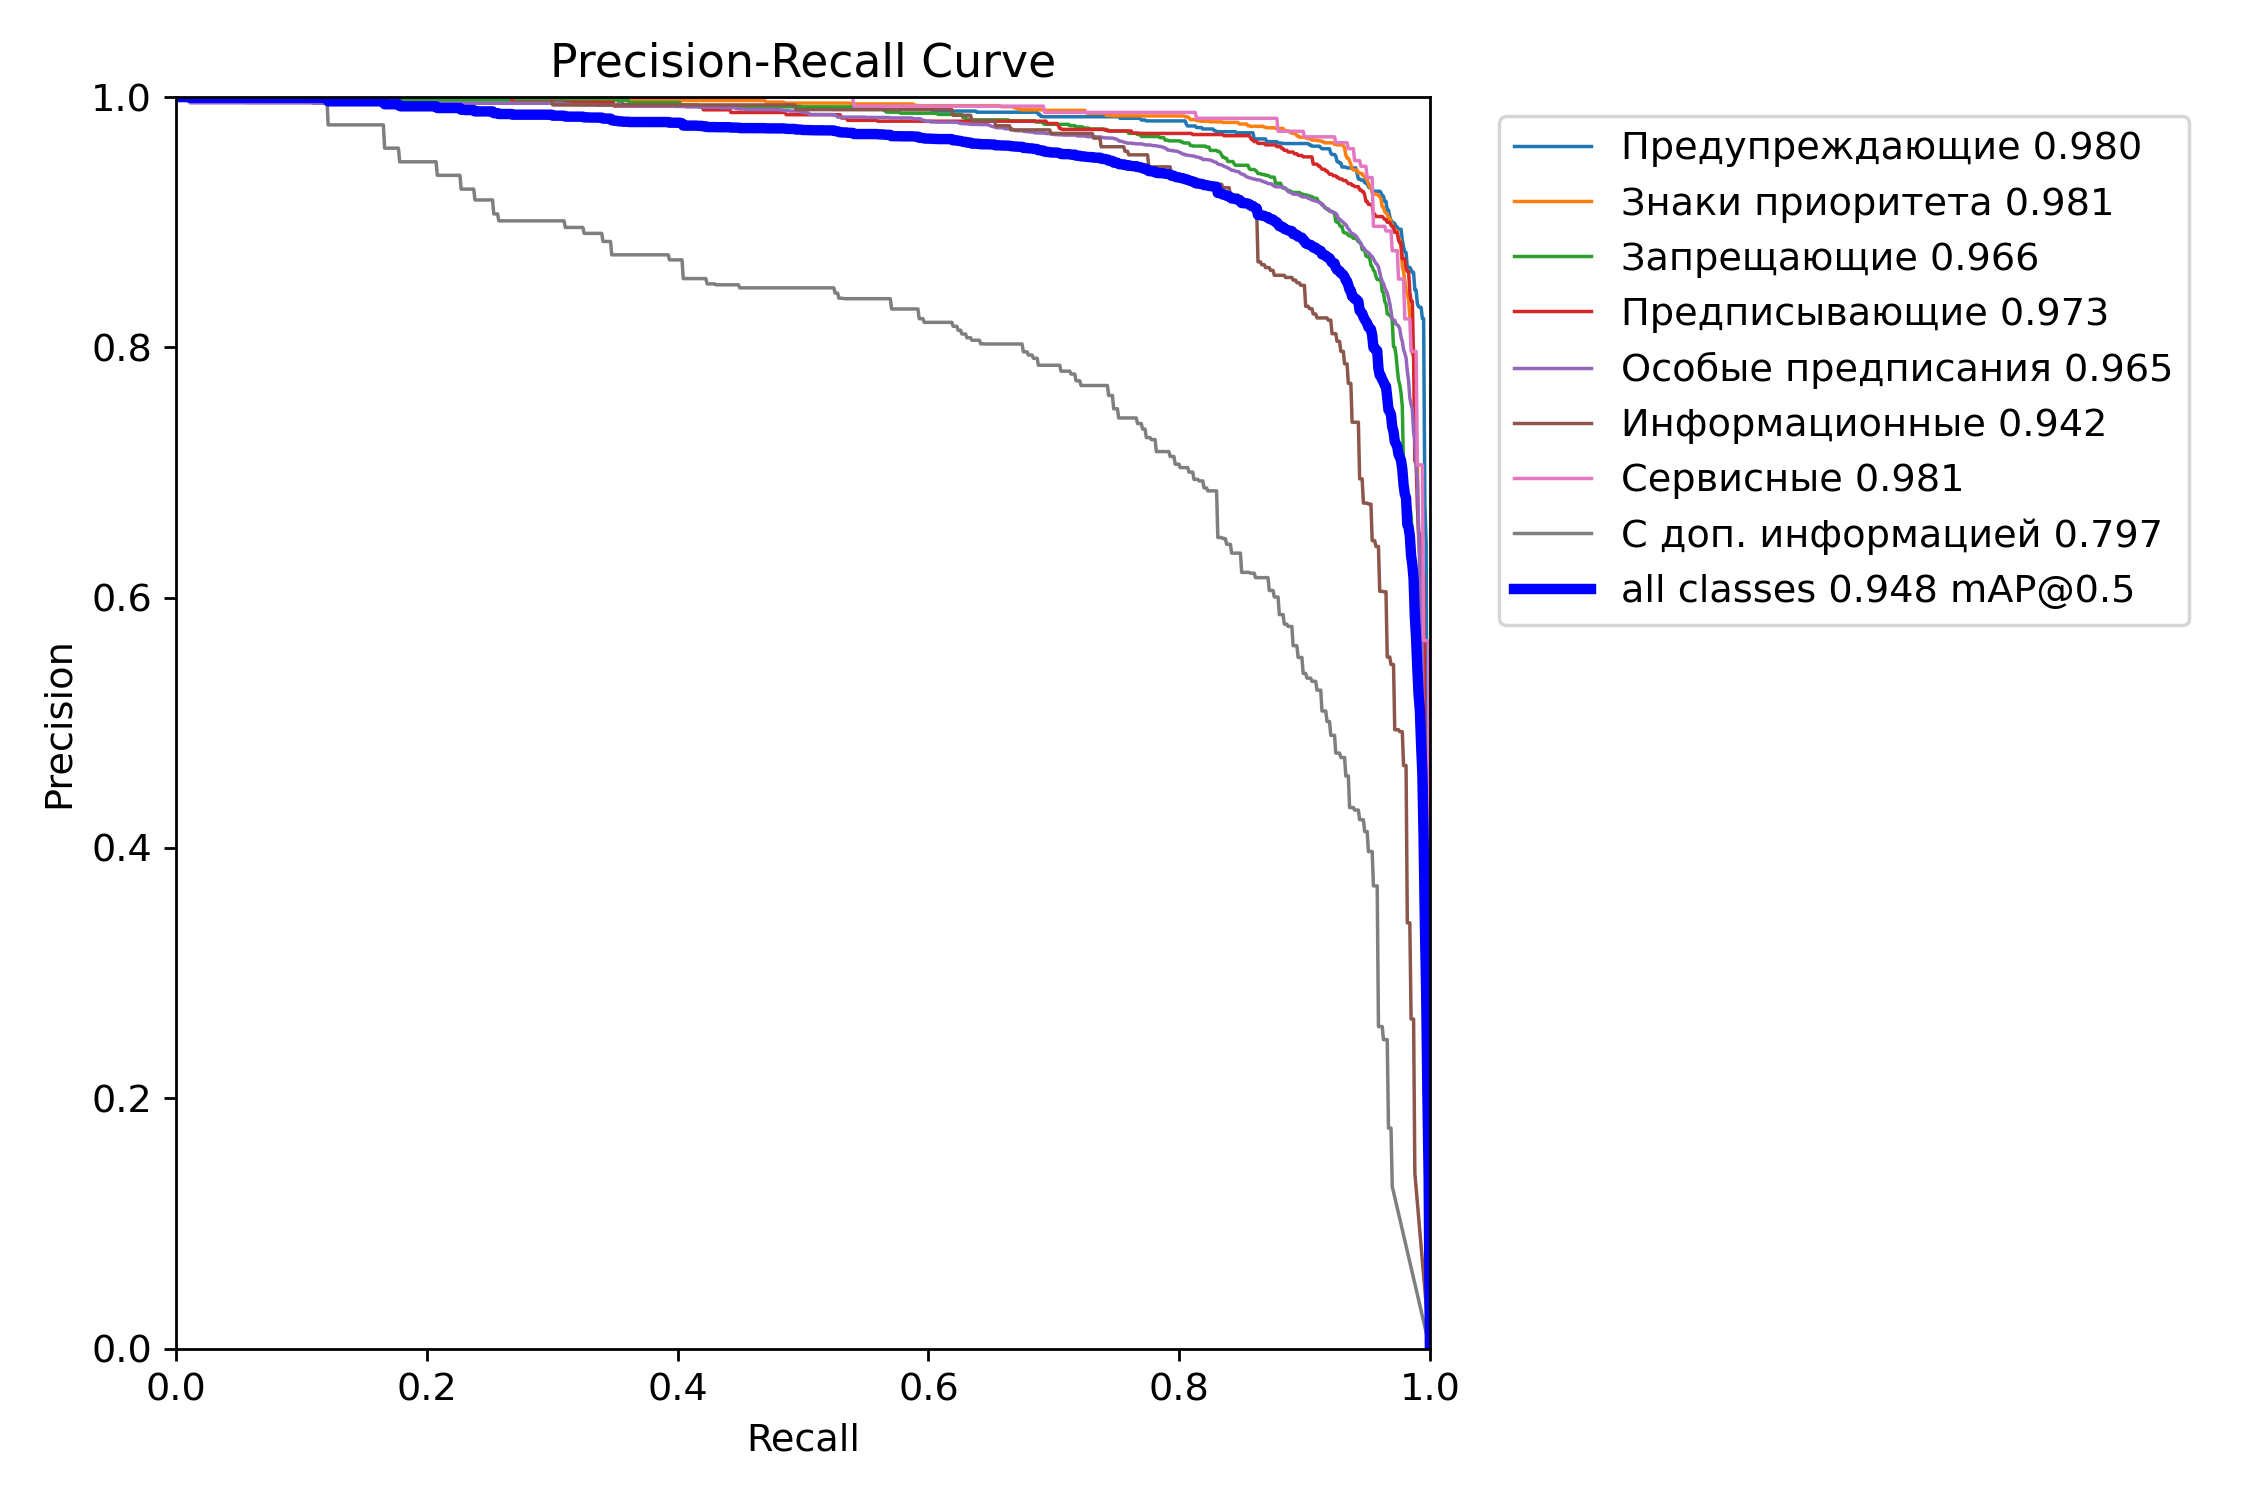

In [8]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/PR_curve.png', width=900, height=600)

**Precision по каждому классу**

Показывает точность модели для каждого класса.

Высокая точность = меньше false positives.

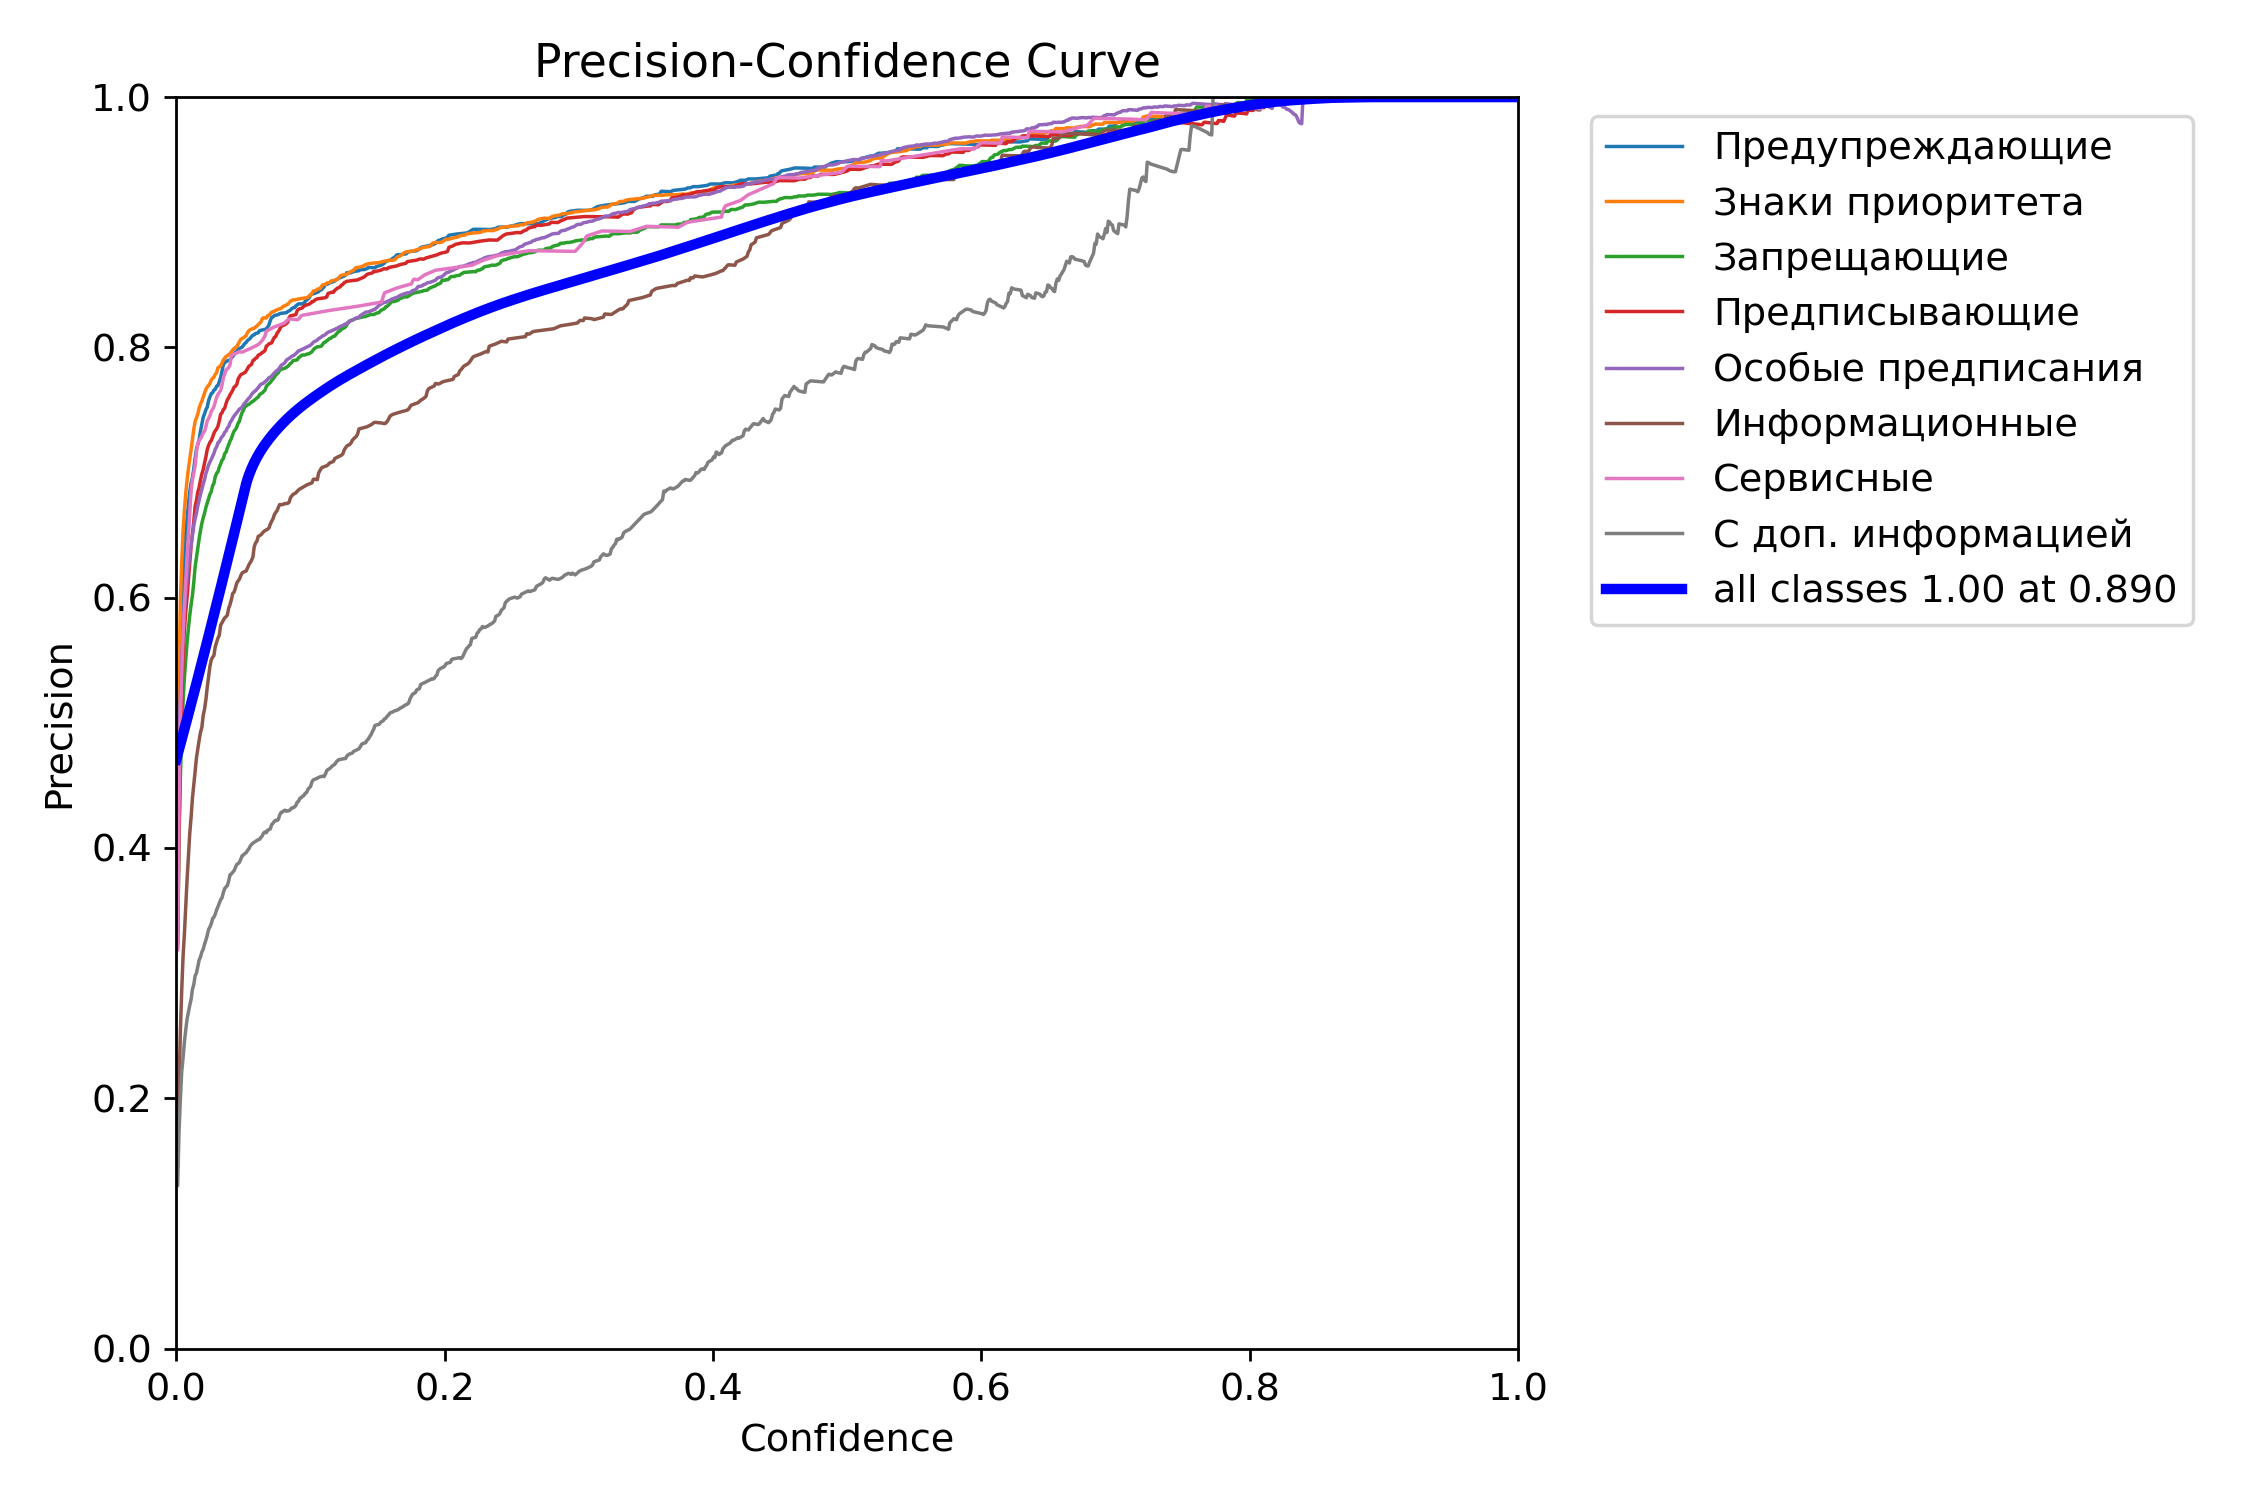

In [9]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/P_curve.png', width=900, height=600)

**F1-метрика по классам**

Гармоническое среднее между точностью и полнотой.

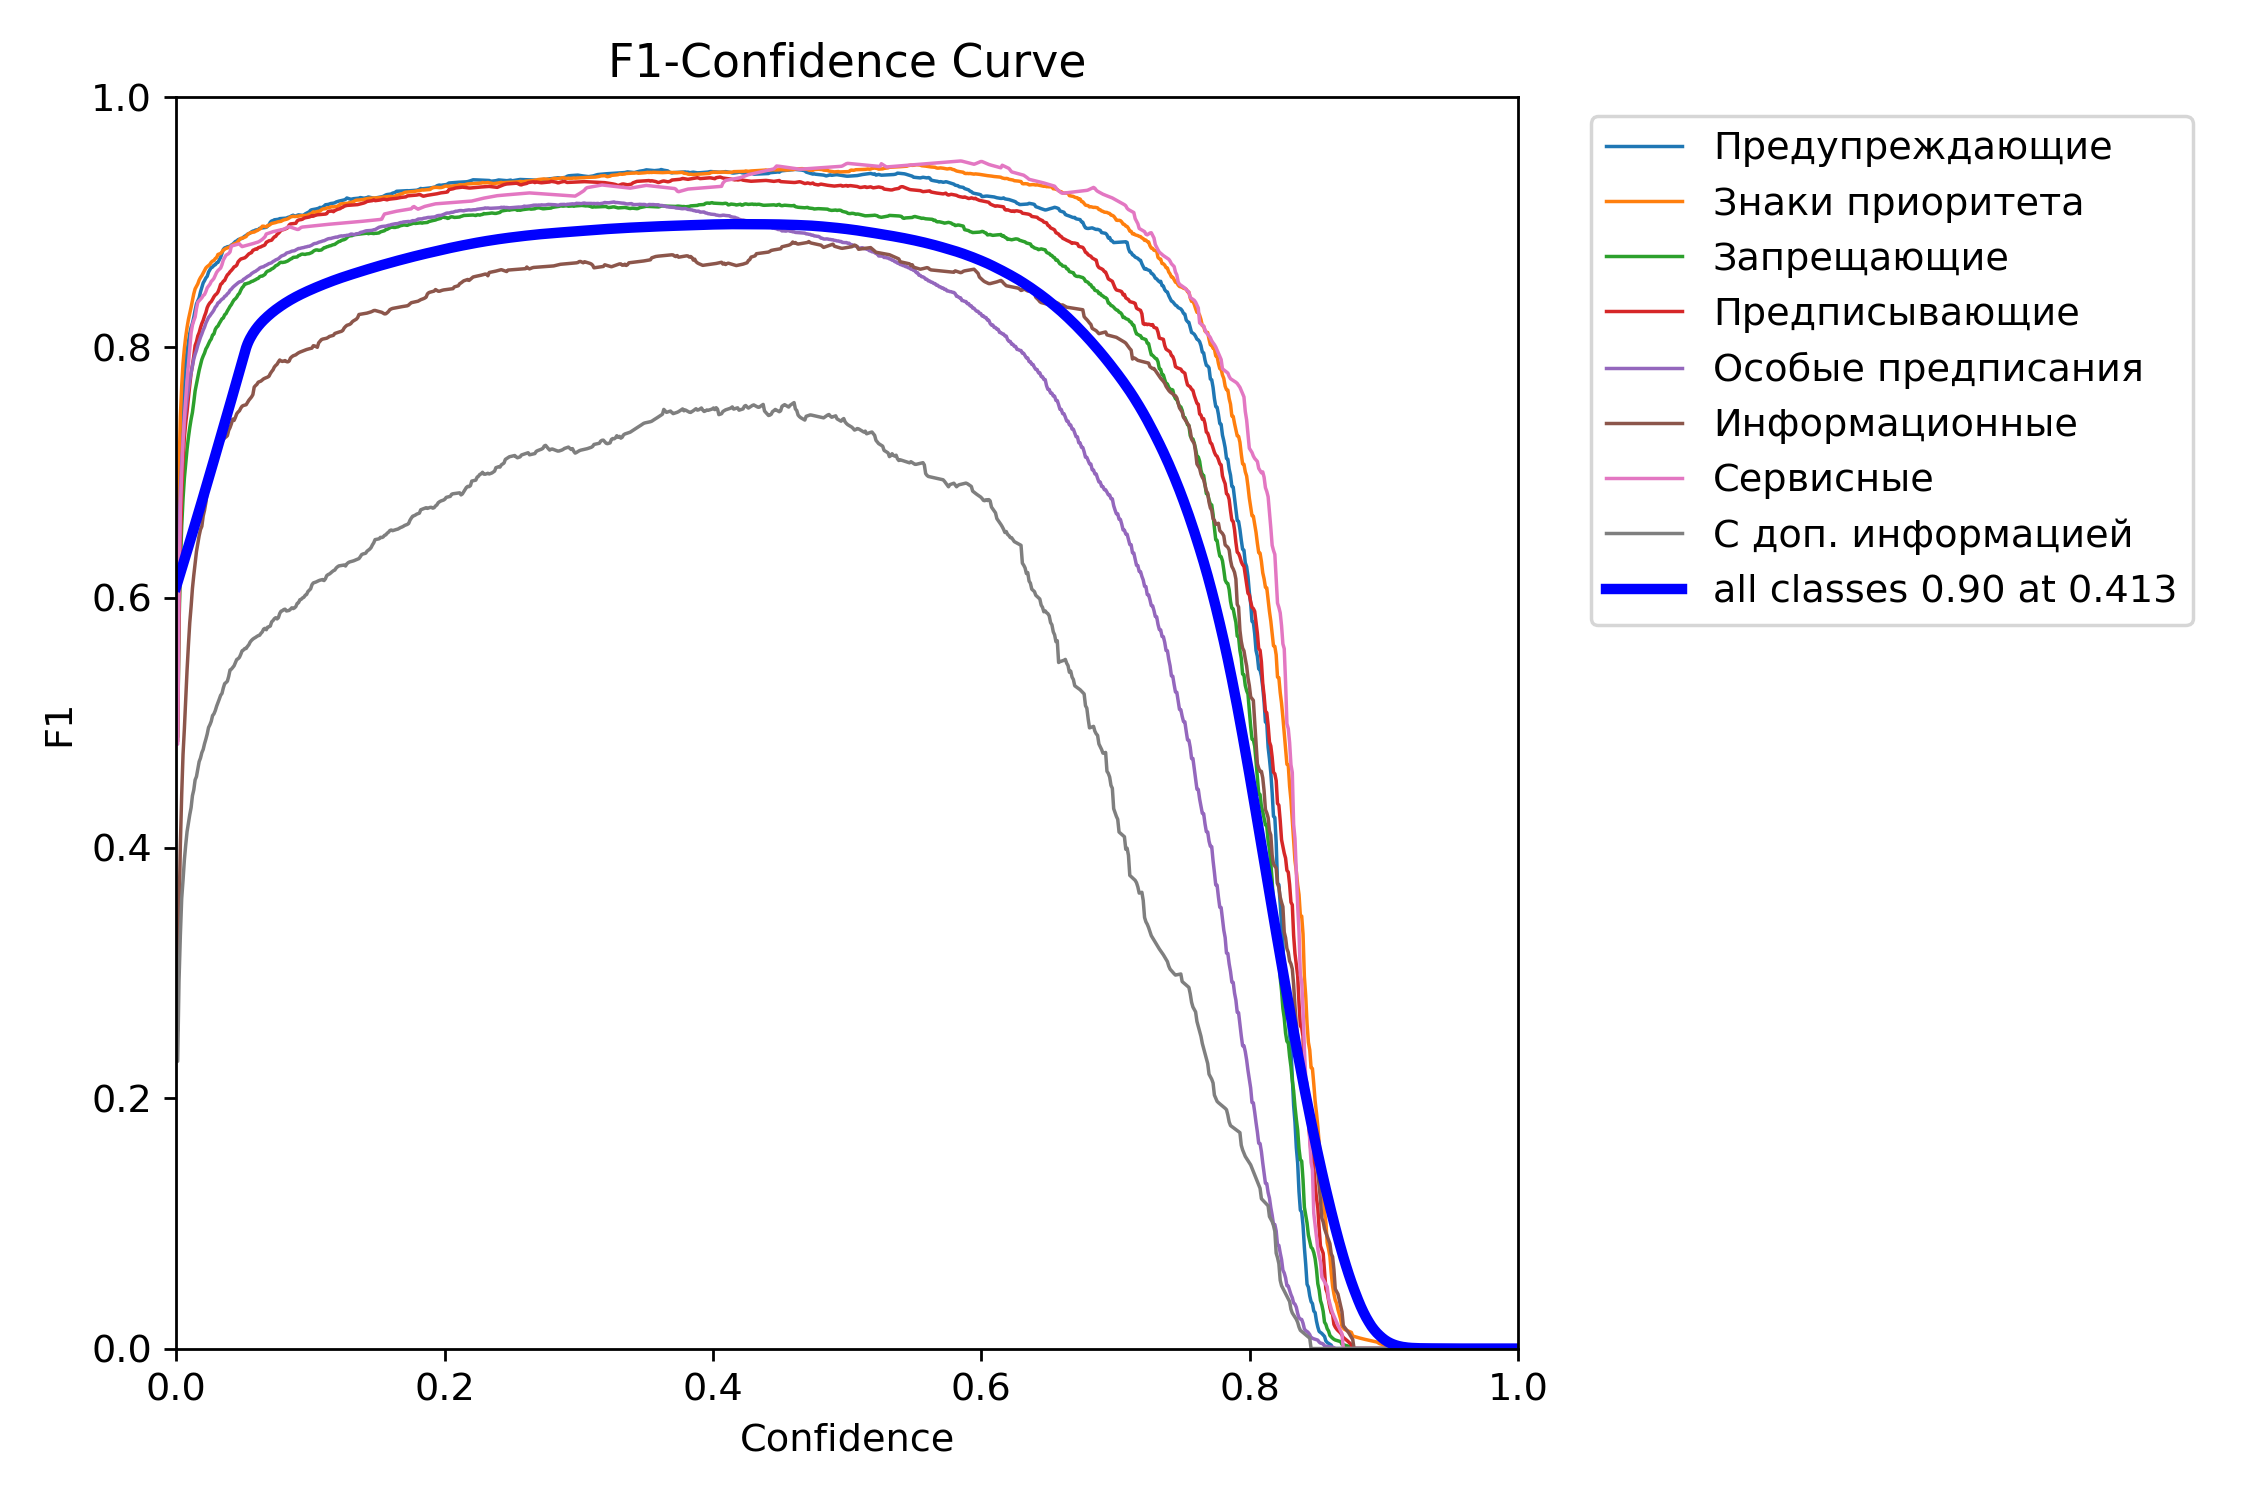

In [10]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/F1_curve.png', width=900, height=600)

**Recall по каждому классу**

Показывает полноту: сколько объектов данного класса удалось найти.

Низкий recall → пропущенные знаки.

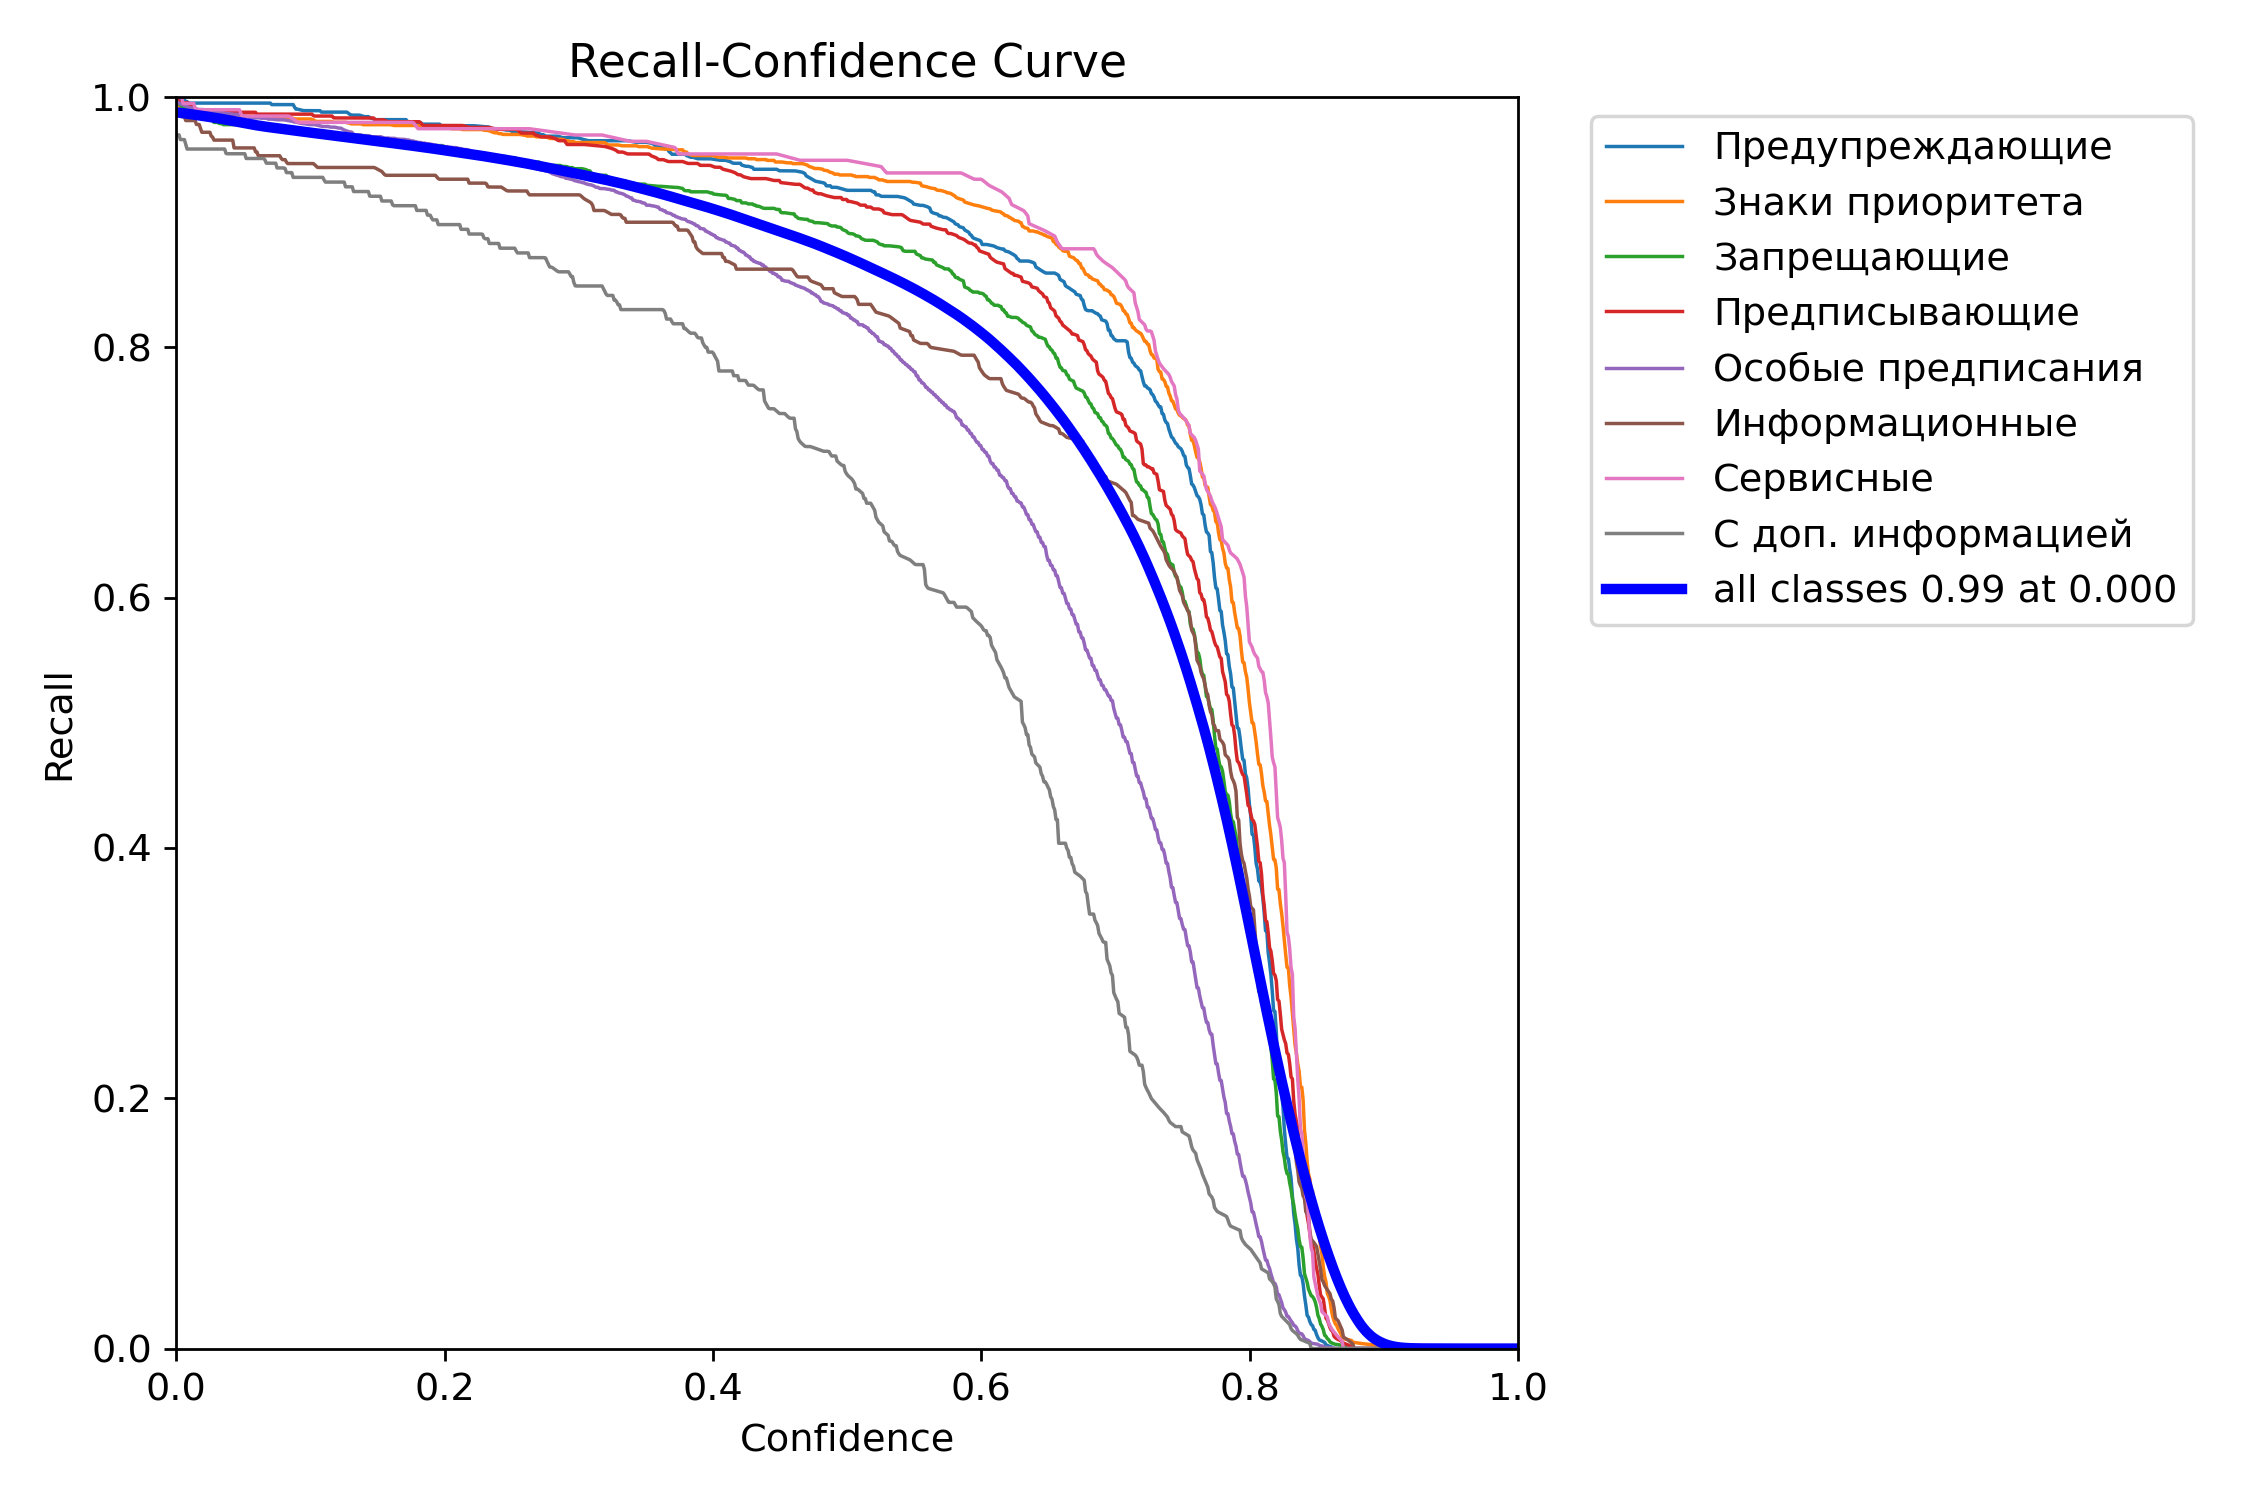

In [11]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/R_curve.png', width=900, height=600)

**Примеры изображений из тренировочного датасета с нанесёнными аннотациями.**

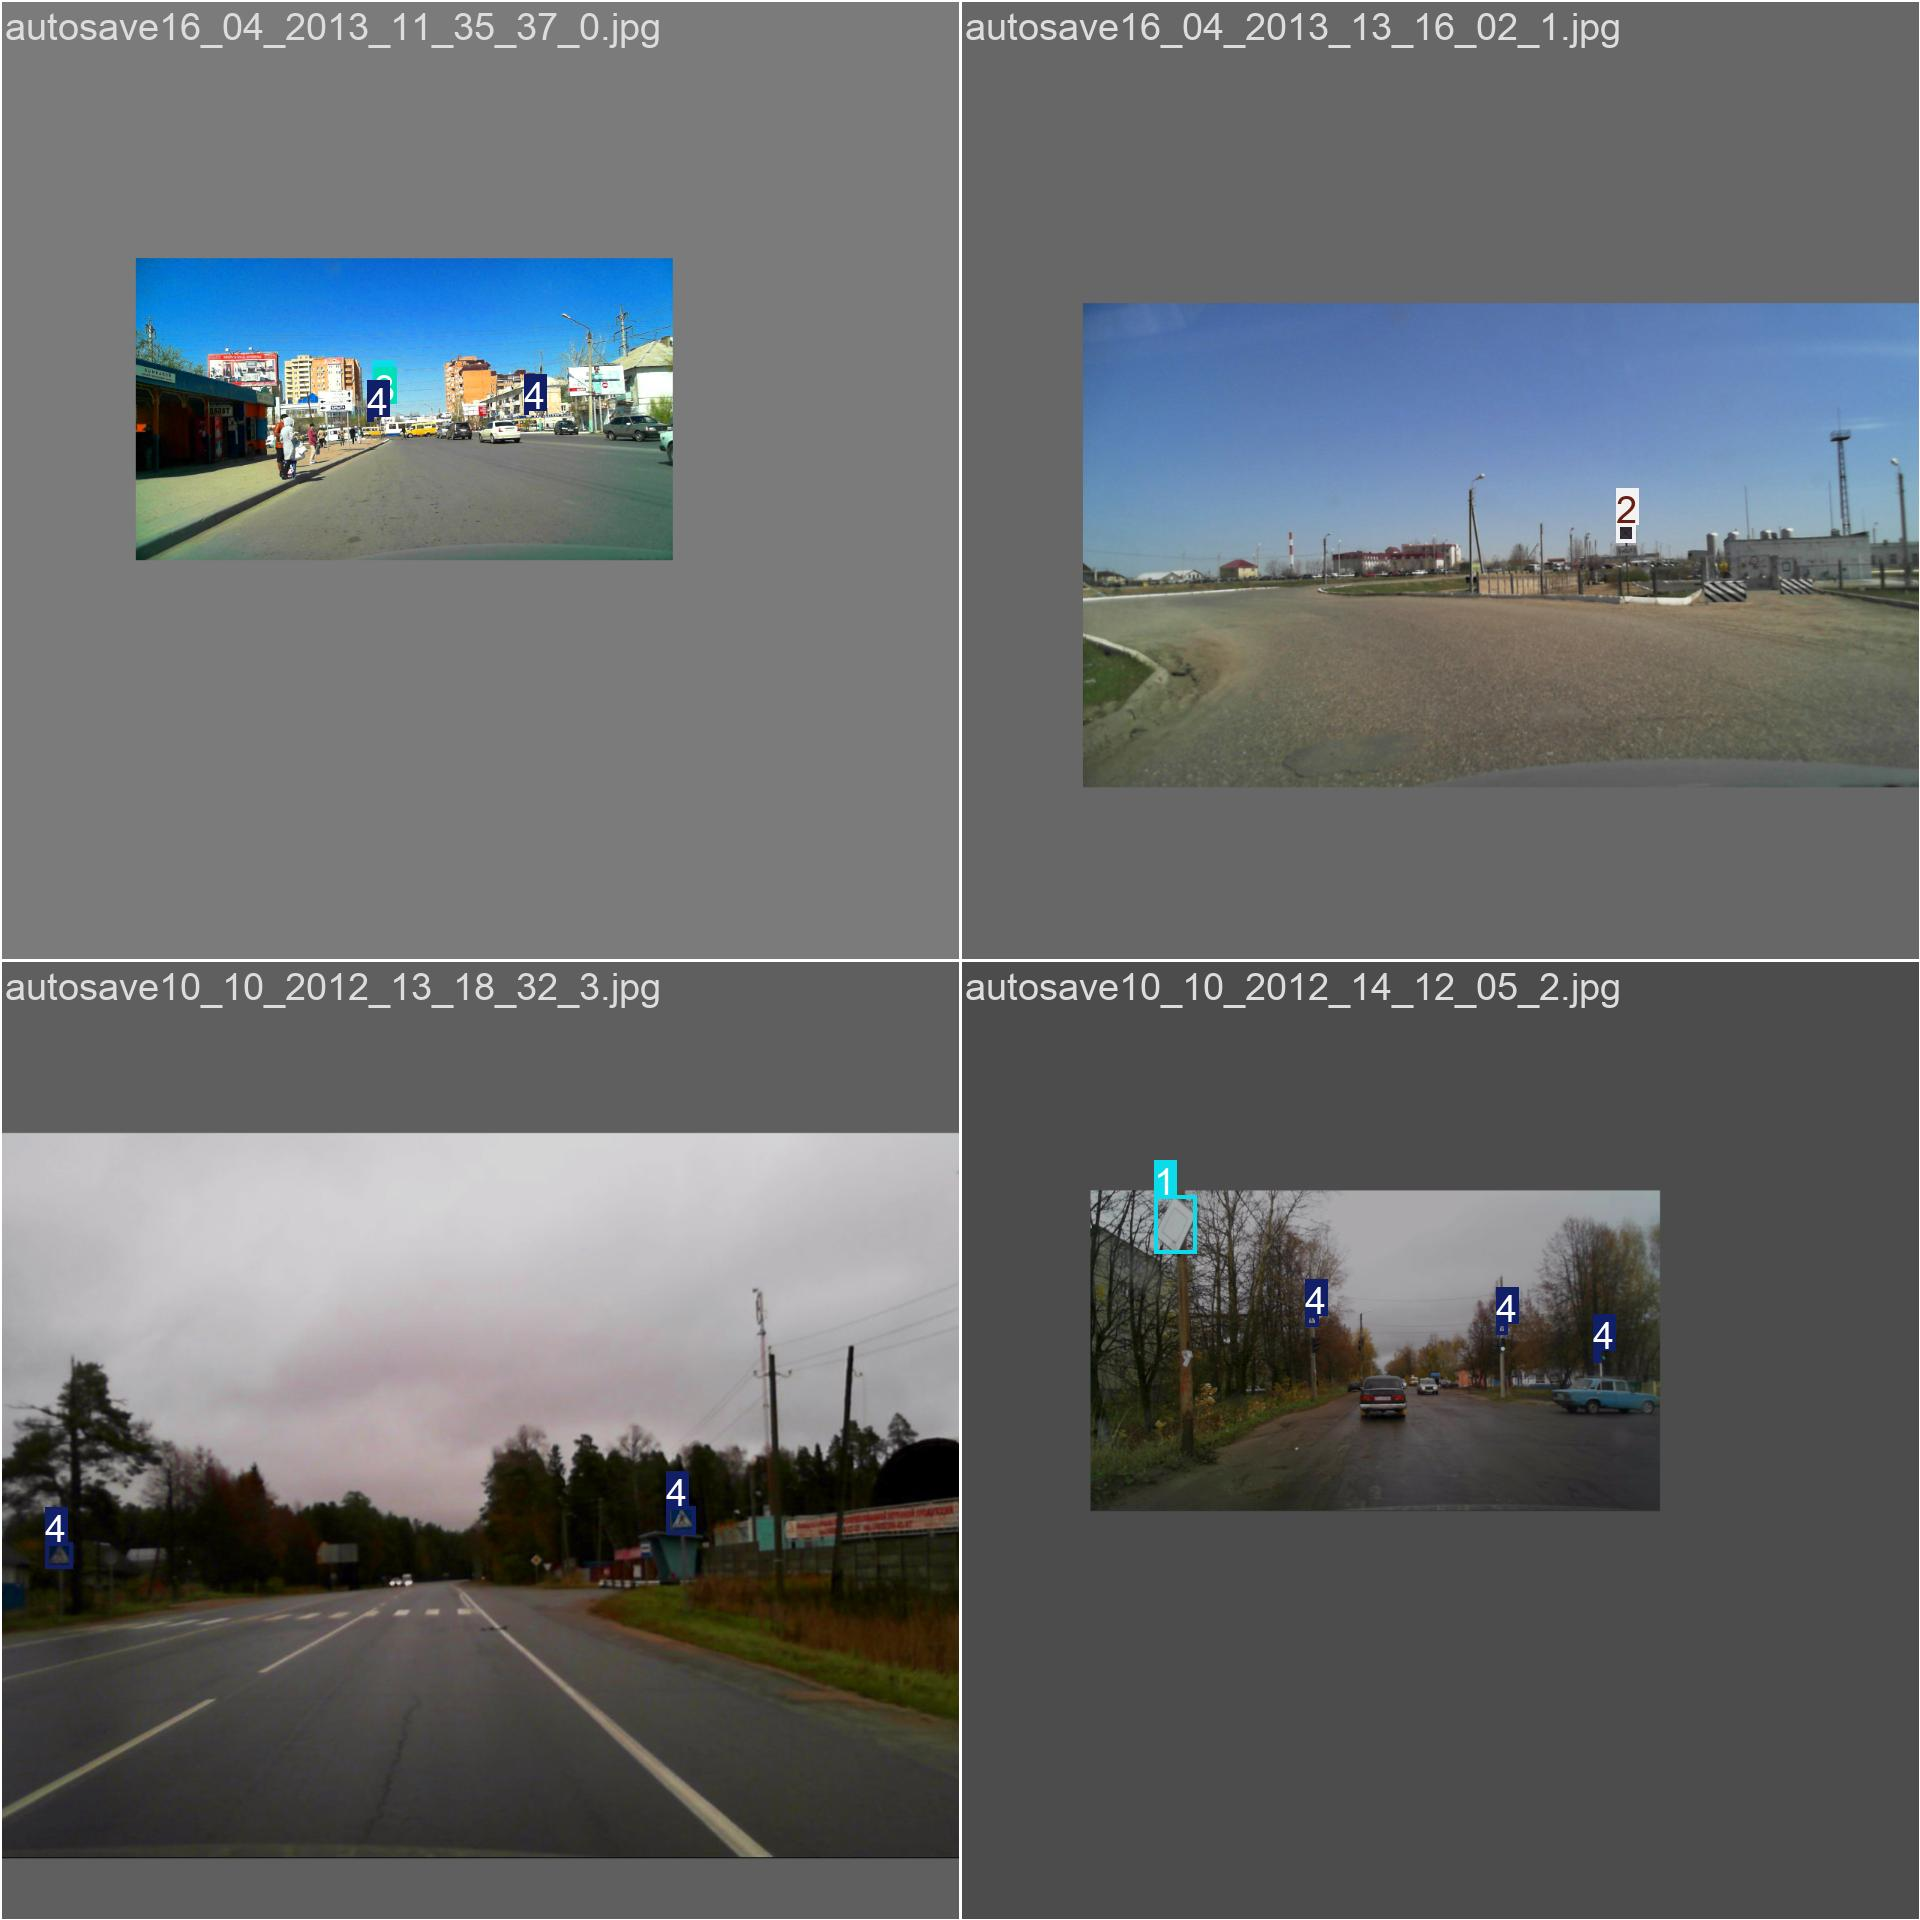

In [12]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/train_batch1.jpg', width=1280, height=720)

**Примеры изображений из валидационного датасета с реальными и предсказанными аннотациями.**

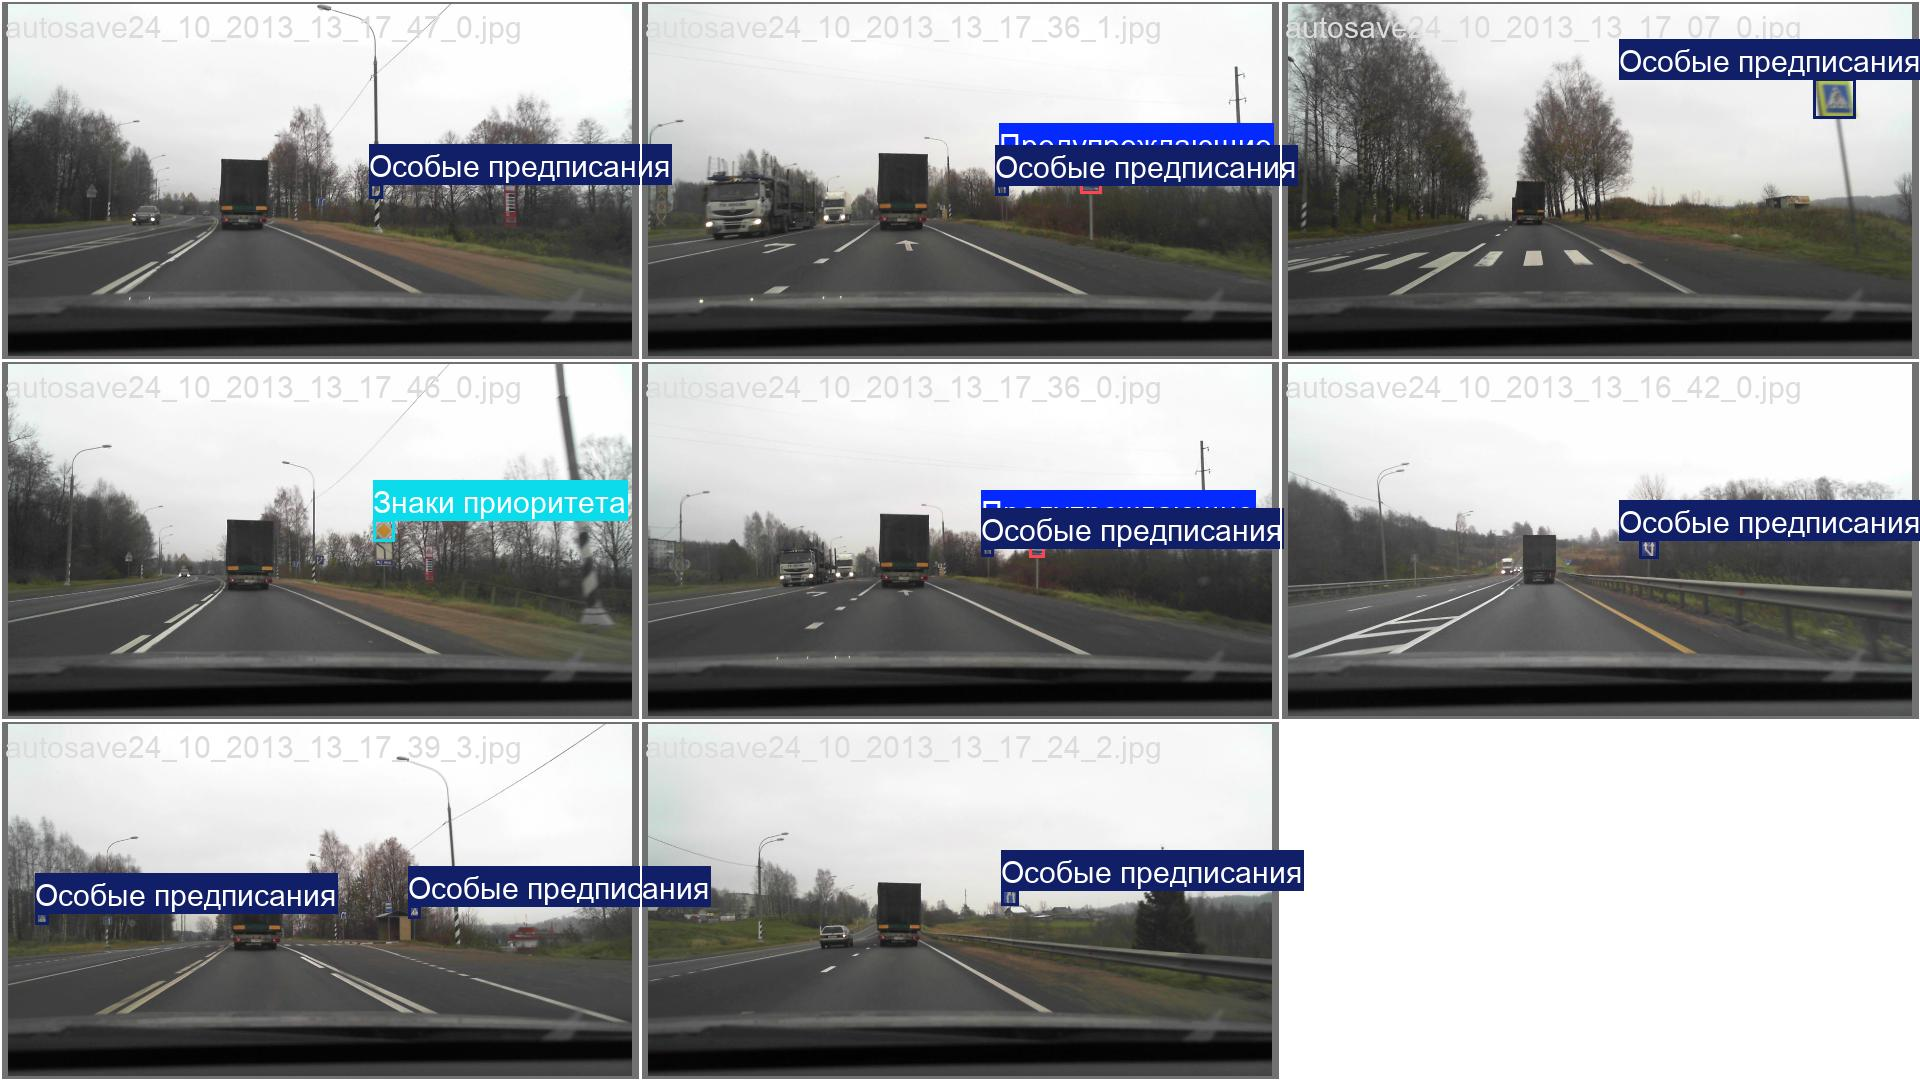

In [13]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/val_batch0_labels.jpg', width=1280, height=720) #True

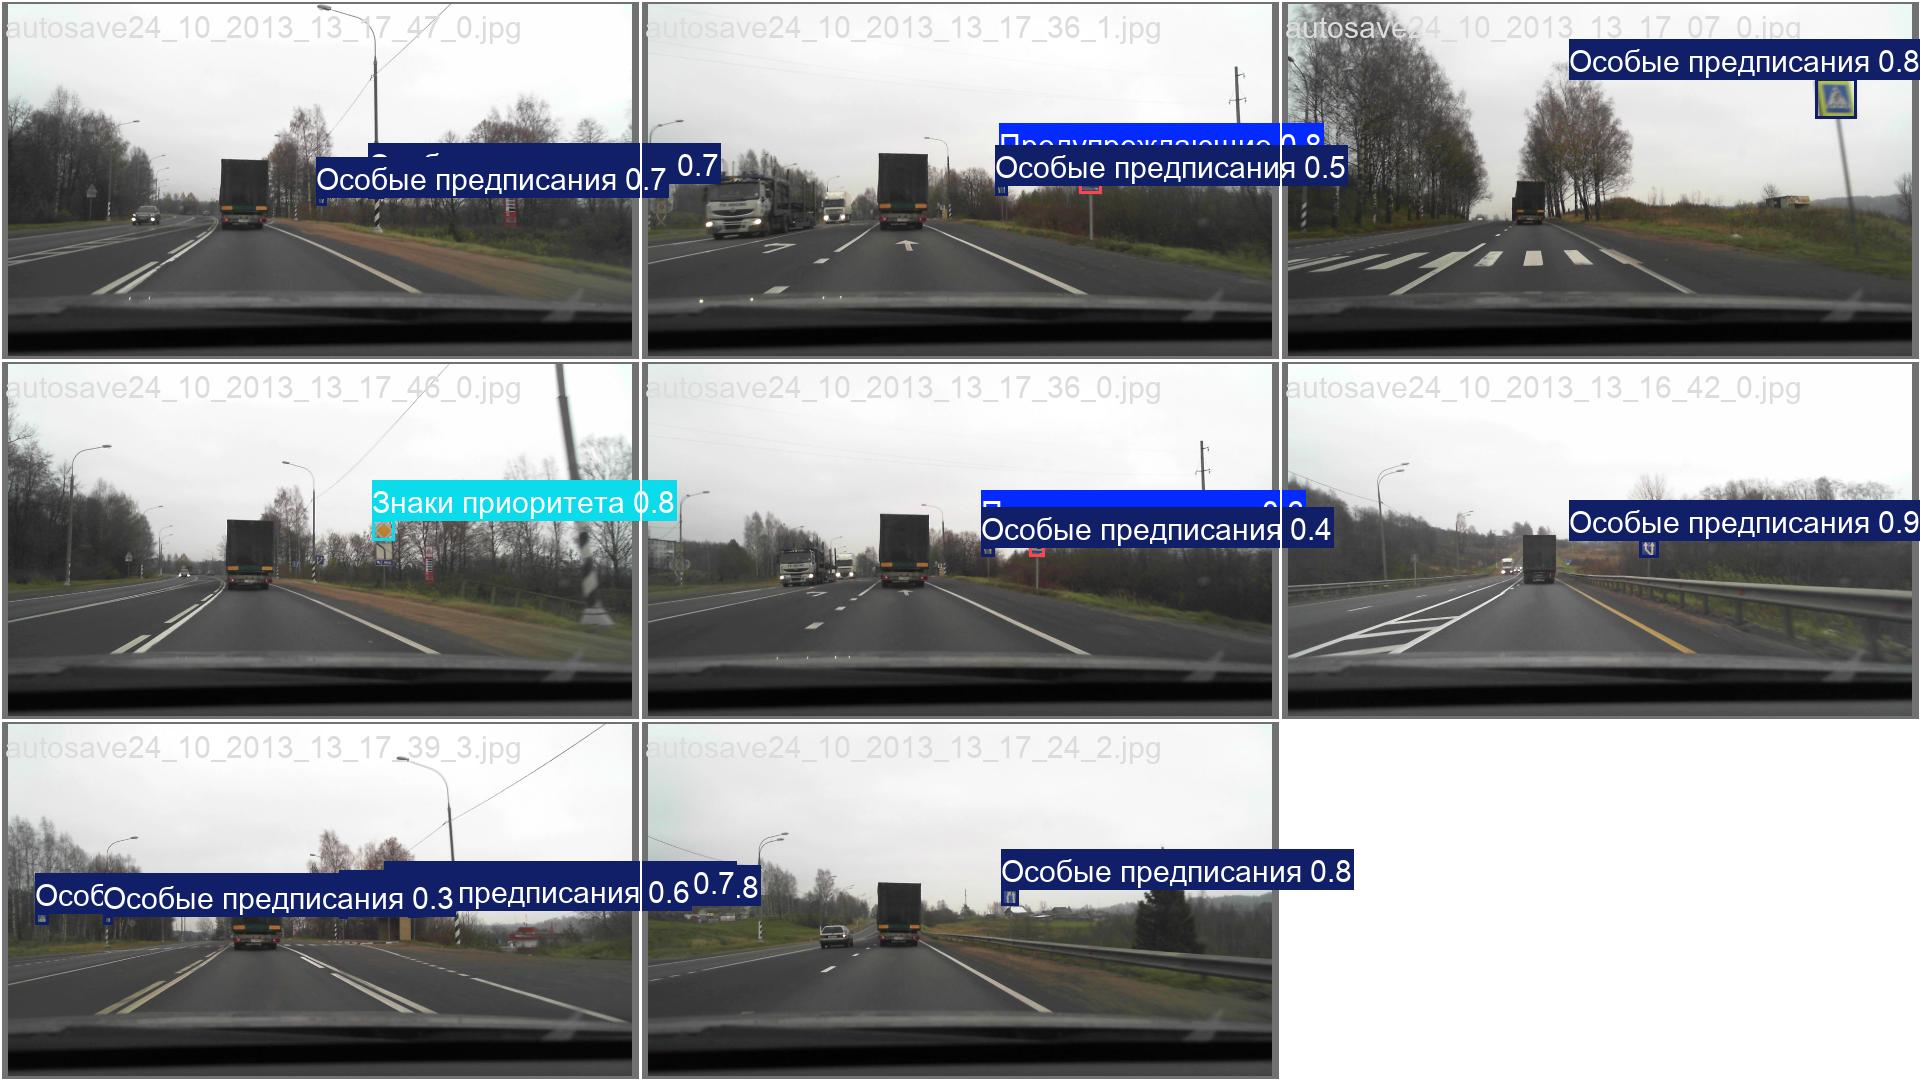

In [14]:
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/val_batch0_pred.jpg', width=1280, height=720) # Predicted

**CSV-таблица со всеми метриками по эпохам**

In [15]:
df_results_aug_1280 = pd.read_csv('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/results.csv')
df_results_aug_1280

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   6635.75         1.28256         1.15132         1.14848   
1      2  13097.20         1.16491         0.84621         1.09679   
2      3  19531.00         1.11996         0.75905         1.07072   
3      4  25939.00         1.08266         0.70120         1.05137   
4      5  32358.10         1.05025         0.65476         1.03638   
5      6  38759.40         1.02528         0.62295         1.02402   
6      7  45133.50         1.00344         0.59581         1.01403   
7      8  51552.00         0.98273         0.57043         1.00315   
8      9  58016.40         0.96276         0.54824         0.99414   
9     10  64609.00         0.94626         0.52978         0.98628   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.84994            0.85981           0.90153   
1               0.86537            0.88016           0.92333   
2               0.86341            0.90032           0.93135   
3               0.87241            0.90380           0.93578   
4               0.87882            0.90604           0.93981   
5               0.88352            0.90112           0.94212   
6               0.89061            0.89685           0.94387   
7               0.89288            0.89567           0.94561   
8               0.89857            0.89603           0.94674   
9               0.89175            0.90486           0.94799   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.65491       0.98805       0.57832       0.96087  0.067001   
1              0.67856       0.95299       0.52403       0.94552  0.033935   
2              0.69207       0.94118       0.49975       0.94058  0.000803   
3              0.69849       0.93440       0.48690       0.93741  0.000703   
4              0.70373       0.92802       0.47896       0.93515  0.000604   
5              0.70938       0.92174       0.47168       0.93301  0.000505   
6              0.71208       0.91850       0.46579       0.93160  0.000406   
7              0.71464       0.91468       0.46105       0.92979  0.000307   
8              0.71597       0.91119       0.45639       0.92816  0.000208   
9              0.71890       0.90799       0.45173       0.92660  0.000109   

     lr/pg1    lr/pg2  
0  0.000333  0.000333  
1  0.000601  0.000601  
2  0.000802  0.000802  
3  0.000703  0.000703  
4  0.000604  0.000604  
5  0.000505  0.000505  
6  0.000406  0.000406  
7  0.000307  0.000307  
8  0.000208  0.000208  
9  0.000109  0.000109

| Столбец | Описание                                                   |
| ------- | ---------------------------------------------------------- |
| `epoch` | Номер текущей эпохи (итерации обучения).                   |
| `time`  | Время, затраченное на текущую эпоху.                       |
| `train/box_loss` | **Потери по координатам bbox** — показывает, насколько предсказанные координаты отличаются от правильных. Чем меньше, тем точнее модель "рисует" рамки. |
| `train/cls_loss` | **Классификационные потери** — как хорошо модель определяет правильный класс для объекта. Высокие значения → модель путается.                           |
| `train/dfl_loss` | **Distribution Focal Loss (DFL)** — используется для более точного определения положения боксов (разбиение координат на интервалы и регрессия).         |
| `metrics/precision(B)` | Precision (точность) — доля верных предсказаний среди всех предсказанных объектов.                                                 |
| `metrics/recall(B)`    | Recall (полнота) — доля правильно найденных объектов среди всех реальных.                                                          |
| `metrics/mAP50(B)`     | **mAP50 (mAP0.5)** — средняя точность (mean Average Precision) при IoU ≥ 0.5. Это ключевая метрика в задачах object detection.           |
| `metrics/mAP50-95(B)`  | **mAP50-95 (mAP0.5-0.95)** — средняя mAP по 10 IoU от 0.5 до 0.95 с шагом 0.05. Это более строгий и объективный показатель качества модели. |
| `val/box_loss`                                                       | bbox losses на валидации — как `train/box_loss`, только на отложенной выборке. |
| `val/cls_loss`                                                       | classification losses на валидации.                                            |
| `val/dfl_loss`                                                       | DFL на валидации.                                                              |
| `lr/pg0`, `lr/pg1`, `lr/pg2` | Learning rate для **разных групп параметров**:  *pg0* — обычно backbone (база модели), *pg1* — head (обнаружение объектов), *pg2* — bias-термы и т.д. Позволяет тонко управлять обучением разных частей модели. |




<Figure size 1200x600 with 0 Axes>

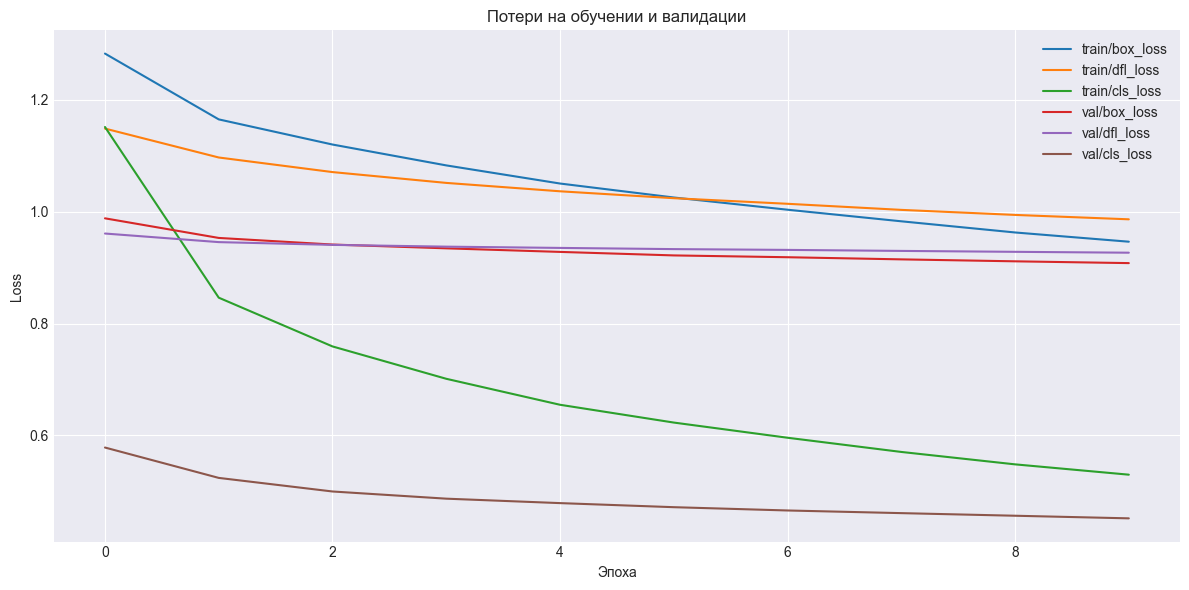

<Figure size 1200x600 with 0 Axes>

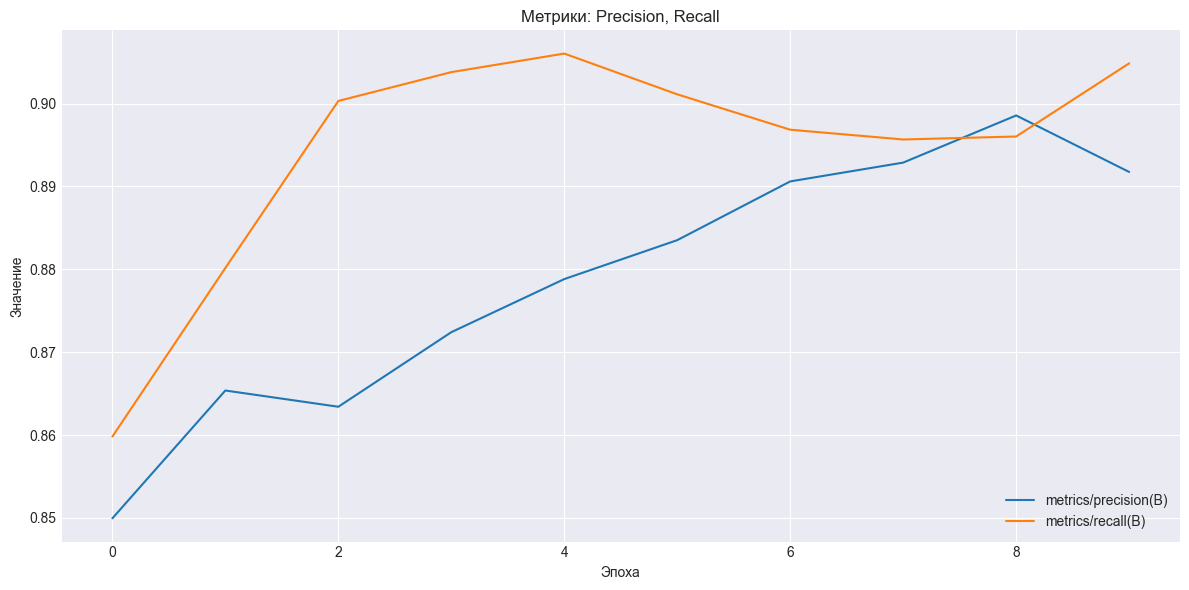

<Figure size 1200x600 with 0 Axes>

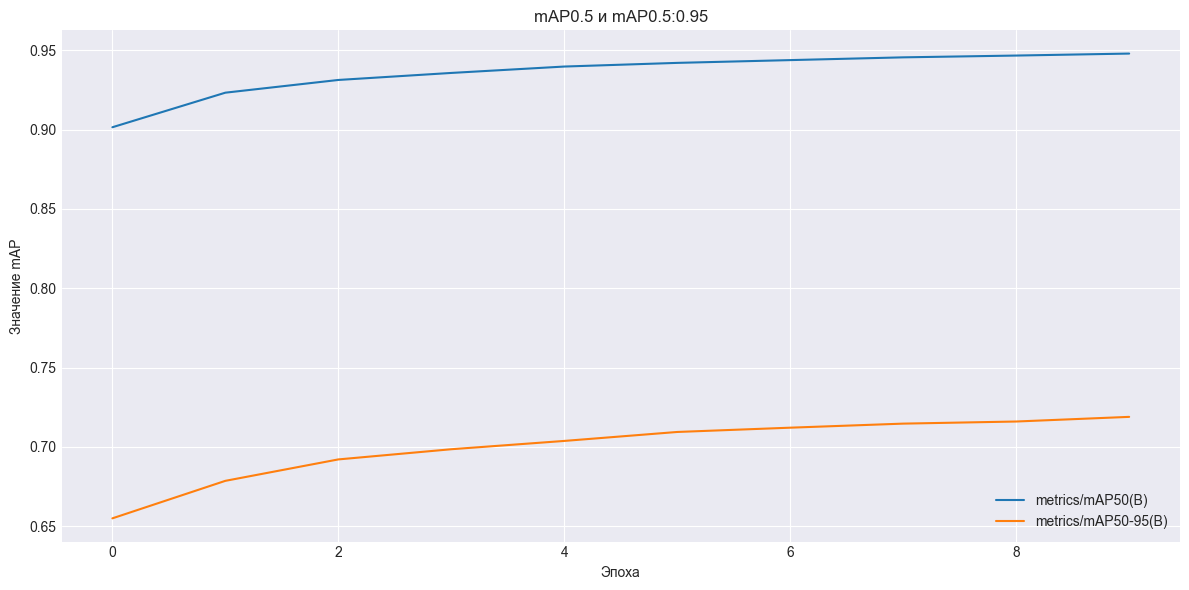

In [16]:
# Настройки стиля графиков
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# График потерь
plt.figure()
df_results_aug_1280[["train/box_loss", "train/dfl_loss", "train/cls_loss",
                        "val/box_loss", "val/dfl_loss", "val/cls_loss"]].plot()
plt.title("Потери на обучении и валидации")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# График точности, полноты и F1
plt.figure()
df_results_aug_1280[["metrics/precision(B)", "metrics/recall(B)"]].plot()
plt.title("Метрики: Precision, Recall")
plt.xlabel("Эпоха")
plt.ylabel("Значение")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# График mAP
plt.figure()
df_results_aug_1280[["metrics/mAP50(B)", "metrics/mAP50-95(B)"]].plot()
plt.title("mAP0.5 и mAP0.5:0.95")
plt.xlabel("Эпоха")
plt.ylabel("Значение mAP")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

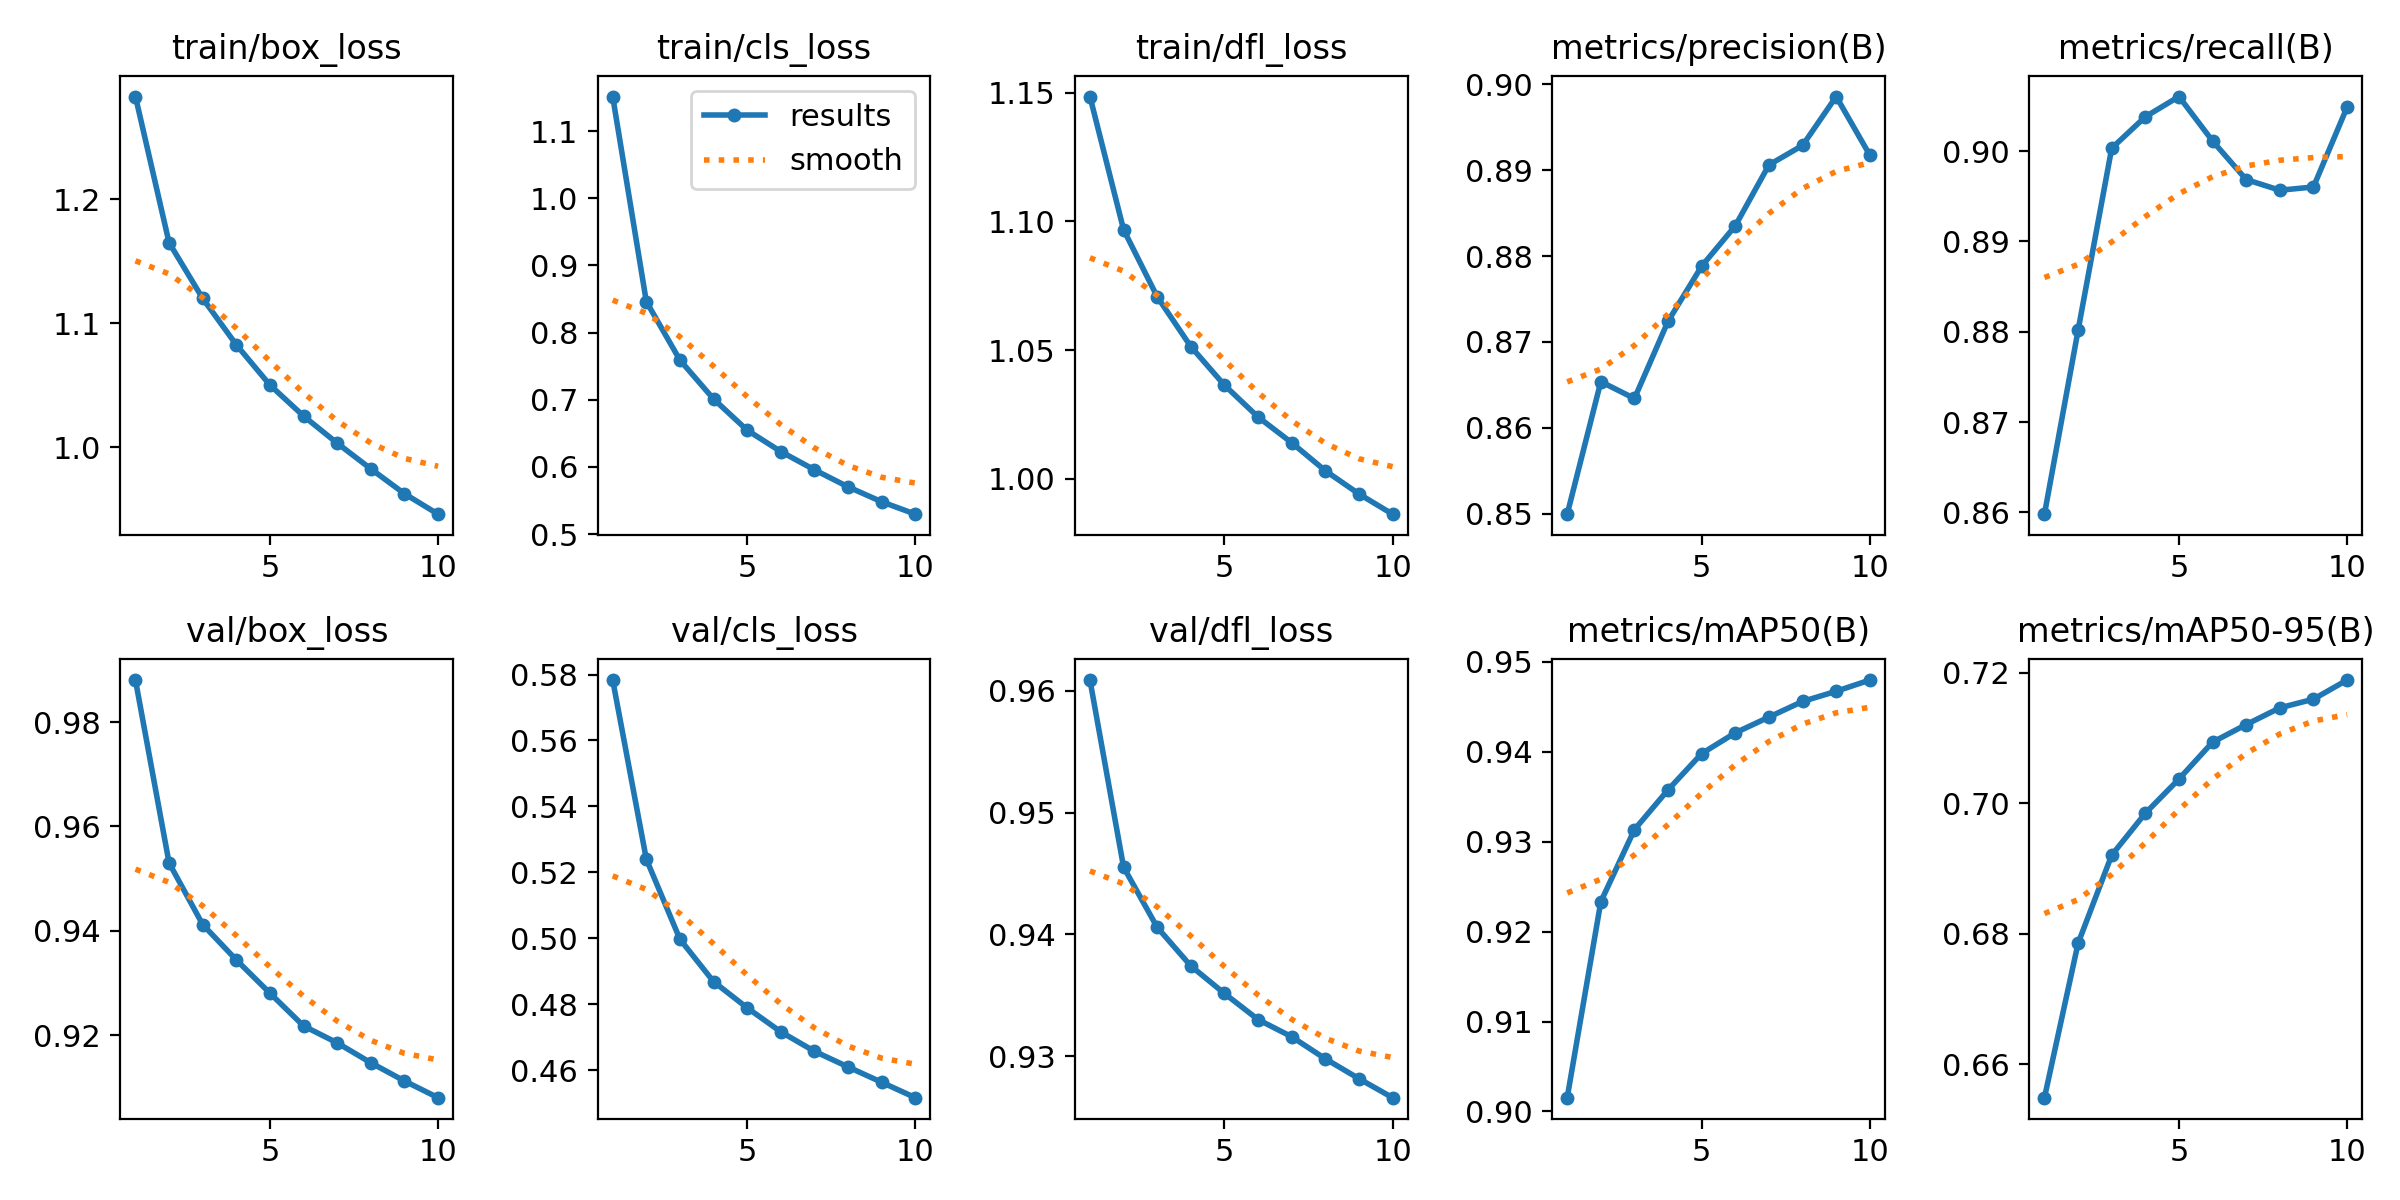

In [17]:
# Те же графики, но по отдельности
display.Image('RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/results.png', width=1200, height=600)

In [3]:
# Функция для вывода метрик модели

def evaluate_yolo_model(model_path, save_to_csv=False):
    """
    Полный анализ метрик YOLO модели
    
    Параметры:
        model_path: Путь к файлу модели (.pt)
        save_to_csv (bool): Сохранять ли метрики в CSV
        
    Возвращает:
        dict: Словарь со всеми метриками
    """
    # Загрузка модели
    model = YOLO(model_path)
    
    # Валидация
    metrics = model.val()
    
    # Сбор данных
    results = {
        'overall': {
            'mAP50': metrics.box.map50,
            'mAP50-95': metrics.box.map,
            'precision': metrics.box.mp,
            'recall': metrics.box.mr,
            'f1': 2*(metrics.box.mp*metrics.box.mr)/(metrics.box.mp+metrics.box.mr),
            'speed_ms': metrics.speed['inference']
        },
        'per_class': []
    }
    
    # Метрики по классам
    class_data = []
    for i in range(len(model.names)):
        class_result = metrics.box.class_result(i)
        class_metrics = {
            'class': model.names[i],
            'precision': class_result[0],
            'recall': class_result[1],
            'mAP50': class_result[2],
            'mAP50-95': class_result[3]
        }
        results['per_class'].append(class_metrics)
        class_data.append(class_metrics)
    
    # Конвертация в DataFrame
    df = pd.DataFrame(class_data)
    
    # Вывод результатов
    print("\n=== ОБЩИЕ МЕТРИКИ ===")
    print(f"mAP50: {results['overall']['mAP50']:.4f}")
    print(f"mAP50-95: {results['overall']['mAP50-95']:.4f}")
    print(f"Precision: {results['overall']['precision']:.4f}")
    print(f"Recall: {results['overall']['recall']:.4f}")
    print(f"F1-score: {results['overall']['f1']:.4f}")
    print(f"Speed: {results['overall']['speed_ms']:.2f} ms/img")
    
    print("\n=== МЕТРИКИ ПО КЛАССАМ ===")
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))
    
    # Сохранение в CSV
    if save_to_csv:
        df.to_csv(f"{model_path[:-3]}_metrics.csv", index=False)
        print(f"\nМетрики сохранены в {model_path[:-3]}_metrics.csv")
    
    return results

In [ ]:
if __name__ == "__main__":
    metrics_11s_aug_2 = evaluate_yolo_model(
        model_path='RTSD_YOLOv11_s_aug_2/yolov11_s_aug_2/weights/best.pt',
        save_to_csv=True
    )

Ultralytics 8.3.112  Python-3.12.8 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 766.2311.7 MB/s, size: 100.8 KB)


val: Scanning C:\Innopolis\Zala_Project\rtsd_yolo_with_aug_2\val\labels.cache... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:33<00:00,  3.34it/s]


                   all       5000       8866      0.896      0.901      0.948       0.72
               744        832      0.934      0.945       0.98      0.742
              1469       1542       0.93      0.951      0.981      0.773
                  1035       1136      0.914      0.915      0.967      0.737
                580        660      0.931      0.936      0.973      0.725
            2383       3913       0.93      0.874      0.964      0.729
                313        320      0.873      0.863      0.942       0.69
                     186        198      0.921      0.955      0.981      0.779
     .         245        265      0.732      0.774      0.797      0.586
Speed: 0.7ms preprocess, 13.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val16

=== ОБЩИЕ МЕТРИКИ ===
mAP50: 0.9479
mAP50-95: 0.7200
Precision: 0.8956
Recall: 0.9015
F1-score: 0.8985
Speed: 13.76 ms/img

=== МЕТРИКИ ПО КЛАССАМ ===
+--------------------+-------------+---